# Exploring the Relationship Between Reddit Sentiment and Stock Price Movements
# 1. Introduction & Hypothesis
**Business/Research Question**  
Is the sentiment in stock-related Reddit posts correlated with short-term stock price movements?

This project conducts an empirical investigation into the relationship between social media sentiment and financial markets.
It aims to determine if a statistically significant correlation exists between online discourse and tech stock performance, by analyzing one year of posts from finance and stock focused subreddits concerning three major tech stocks - NVIDIA, Tesla, and Google.

**Initial Hypothesis**  
There is a statistically significant positive correlation between weekly **Reddit sentiment scores** and weekly **stock returns** for the selected technology stocks.

## 2. Methodology Overview
To test this hypothesis, I will:

1. **Collect Data:**  
   Gather historical stock price data for NVDA, TSLA, and GOOGL and scrape Reddit posts mentioning these stocks from relevant subreddits over the same time period.  
2. **Process Data:**  
   - Clean the text data and calculate sentiment scores for individual Reddit posts using two distinct NLP libraries: **TextBlob** and **VADER**
   - Calculate weekly stock returns from price data
   - Aggregate post-level sentiment to weekly averages
   - Merge weekly sentiment and stock return datasets  
3. **Analyze & Visualize:**  
   Employ descriptive statistics, visualizations, and correlation analysis to explore the relationship between weekly sentiment and stock returns.  
4. **Critically Assess:**  
   Evaluate the strength, significance, and practical importance of any found relationships, and discuss methodological limitations.

### 2.1 Data Source Justification
**A. Subreddit Selection**  
The Reddit data is from a curated list of finance-focused communities:
    "r/wallstreetbets", "r/stocks", "r/investing", "r/StockMarket", and "r/StocksAndTrading".
* **Inclusion Justification**  
These subreddits were chosen because their primary purpose is the discussion of stocks and investing. This focus provides a direct pipeline to potential market sentiment, as opposed to general news or technology forums where discussion may not be investment-oriented.
* **Exclusion Justification**  
Highly specialized subreddits like "r/Options" (focused on short-term, tactical options trading) and "r/SecurityAnalysis" (focused on long-term, fundamental valuation) were excluded.
While relevant to finance, their highly specific contexts and investment horizons would introduce distinct, competing signals, complicating the goal of capturing a broader, more general measure of retail investor sentiment.
* **Bias Acknowledgment**  
It is recognized that the selected subreddits represent a spectrum of investor psychologies (e.g. the speculative nature of "r/wallstreetbets" vs. the long-term focus of "r/investing"). This internal variation is a noted characteristic of the dataset.

**B. Stock Selection**  
The analysis focuses on three stocks: **NVIDIA (NVDA)**, **Tesla (TSLA)**, and **Alphabet (GOOGL)**.  
These companies were selected based on three key criteria:
1.  **High Profile & Discussion Volume**  
       They are among the most discussed companies on social media and financial news, ensuring a sufficient volume of Reddit posts for a robust analysis.
2.  **Significant Volatility**  
       Both NVDA and TSLA have historically shown significant price volatility. GOOGL provides a slightly more stable counterpoint. This mix is ideal for testing if sentiment correlates with price movements, as volatile stocks have more "signal" to detect.
3.  **Diversity within Tech**  
       While all are in the technology sector, they represent different sub-sectors (semiconductors, electric vehicles/clean energy, internet services/ads), allowing for a more nuanced exploration of whether the sentiment relationship holds across different business models.

**C. Timeframe Justification**  
The analysis covers a one-year historical period. This timeframe was primarily determined by a practical constraint: the Reddit API (via the PRAW library) allows for the efficient extraction of posts from up to one year in the past. To ensure a synchronized analysis, the stock price data was collected for the identical one-year window. This provides a balanced dataset with around one year of weekly observations for each stock, which is sufficient for a robust correlation analysis while respecting data collection limits.
- **Stock Data**: Downloaded on 28.10.2025.
- **Reddit Data**: Collected on 28.10.2025.

### 2.2 Success Criteria
The project will be considered successful if it can:
*   **Quantify the Relationship**  
  Identify a statistically significant correlation coefficient between weekly aggregated sentiment scores and weekly stock returns.
*   **Critically Evaluate the Findings**  
  Provide a reasoned discussion on the practical significance (or lack thereof) of any correlation found, acknowledging confounding factors and the fundamental difference between correlation and causation.

### 2.3 Temporal Aggregation Strategy

The relationship between sentiment and stock returns may vary across different time horizons. After considering daily and weekly alternatives, I selected weekly aggregation for this analysis:

**Analysis Approach: Weekly Alignment**
- **Alignment**: Friday as the end of the week date (end of trading week)
- **Weekly Stock Returns**: Percentage change between Friday Closing Price and previous Friday Closing Price
- **Weekly Reddit Sentiment**: Post-Sentiments from Saturday to Friday aggregated to weekly averages
- **Only complete weeks** included in the final analysis

**Implementation:**
- Both datasets use Friday as week-ending date
- First and last week will be excluded from analysis if incomplete

**Justification:** This approach smooths out the high noise of daily fluctuations while still capturing the relatively fast-moving nature of social media sentiment. It provides a robust number of aligned data points (close to a year date range) for robust statistical testing while ensuring temporal consistency between sentiment signals and price movements.

### 2.4 Initial Considerations and Limitations
Before beginning the analysis, it is crucial to acknowledge key limitations that frame our interpretation of the results:

* **Correlation vs. Causation**  
  This study can identify a correlation, but it cannot prove causation. A positive relationship does not mean Reddit sentiment causes stock price moves. The reverse could be true (price moves influence sentiment), or both could be driven by an external factor like news events.

* **Confounding Variables**  
  Stock prices are influenced by countless factors (e.g., earnings reports, economic data, geopolitical events). Our analysis, which only looks at sentiment, will not account for these, which is a significant limitation.

* **Sample Bias**  
  The sentiment is derived only from Reddit users, who are not representative of the entire market of investors. The findings are specific to this population and platform.

This focused approach ensures methodological consistency between hypothesis testing and data analysis.

### 2.5 Analytical Approach

**Descriptive Statistics**  
All summary statistics and averages reported in this analysis use the arithmetic mean for consistency and interpretability. This includes post volumes, sentiment scores, and other aggregated metrics.

**Correlation Analysis**  
Pearson correlation coefficients will be used to assess relationships between weekly sentiment scores and stock returns, as this is appropriate for continuous variables and aligns with our hypothesis testing approach.

## 3. Packages Installation and Imports

**Note:** The following cell installs the necessary Python packages. This is only required once per runtime environment.

In [1]:
# Install required packages
!pip install yfinance pandas numpy matplotlib seaborn vaderSentiment textblob python-dotenv statsmodels praw

In [402]:
# Utils
import os
import numpy as np
import pandas as pd
from scipy.stats import skew, pearsonr
from dotenv import load_dotenv
from datetime import datetime, timedelta

# APIs & Web
import praw
import yfinance as yf

# NLP & Sentiment
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Jupyter Notebook Magic for inline plots
%matplotlib inline

load_dotenv() # Loads REDDIT_CLIENT_ID, REDDIT_CLIENT_SECRET, REDDIT_USER_AGENT

True

## 4. Data Collection & Preparation

This section implements the data collection pipeline described in Section 2, gathering and preparing both stock market data and Reddit sentiment data for correlation analysis.

### 4.1 Stock Data Collection

In [362]:
# Configuration
data_dir = "./data"
stock_tickers = ["NVDA", "TSLA", "GOOGL"]

# Create data directory if it doesn't exist
os.makedirs(data_dir, exist_ok=True)

def load_stock_data_from_files(tickers=stock_tickers):
    """
    Load stock price data from saved CSV files.
    
    Args:
        tickers (list): List of stock ticker symbols.
        
    Returns:
        DataFrame: Combined DataFrame with all stocks and 'ticker' column
        
    Raises:
        FileNotFoundError: If any stock data file is missing
    """
    stock_data_list = []
    
    print("Loading saved stock data...")
    for ticker in tickers:
        file_path = os.path.join(data_dir, f"stock_data_{ticker}.csv")
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"Stock data file not found: {file_path}")
        
        try:
            df = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')
            df['ticker'] = ticker  # Add ticker column
            stock_data_list.append(df)
            print(f"✓ Loaded data for {ticker} (Shape: {df.shape})")
            
        except Exception as e:
            print(f"✗ Loading stock data for {ticker} failed: {e}")
            raise
    
    # Combine all stocks into one DataFrame
    combined_data = pd.concat(stock_data_list, ignore_index=False)
    return combined_data

def download_and_save_stock_data(tickers=stock_tickers):
    """
    Download fresh stock data and save to CSV files.
    
    Args:
        tickers (list): List of stock ticker symbols.
        
    Returns:
        DataFrame: Combined DataFrame with all stocks and 'ticker' column
    """
    stock_data_list = []
    
    print("Downloading fresh stock data...")
    end_date = datetime.now()
    start_date = end_date - timedelta(days=365)
    
    for ticker in tickers:
        try:
            # Download data
            df = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True, progress=False)
            if df.empty:
                print(f"✗ No data downloaded for {ticker}")
                continue

            # Clean up column structure
            df.columns = df.columns.droplevel(1)
            df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
            df['ticker'] = ticker  # Add ticker column
            
            stock_data_list.append(df)
            print(f"✓ Downloaded data for {ticker} (Shape: {df.shape})")
            
            # Save the individual DataFrame (for future loading)
            file_path = os.path.join(data_dir, f"stock_data_{ticker}.csv")
            df_without_ticker = df.drop(columns=['ticker'])  # Save without ticker column
            df_without_ticker.to_csv(file_path, index_label='Date')
            print(f"  Saved to {file_path}")
            
        except Exception as e:
            print(f"✗ Downloading stock data for {ticker} failed: {e}")
    
    # Combine all stocks into one DataFrame
    combined_data = pd.concat(stock_data_list, ignore_index=False)
    return combined_data


print("=== STOCK DATA LOADING ===")
try:
    stock_data_raw = load_stock_data_from_files()
    data_source = "saved files"
    print("✓ Successfully loaded all stock data from saved files")
    
except FileNotFoundError as e:
    print(f"⚠ {e}")
    print("Note: Download functionality disabled")
    # stock_data_raw = download_and_save_stock_data()
    # data_source = "fresh download"
    raise

=== STOCK DATA LOADING ===
Loading saved stock data...
✓ Loaded data for NVDA (Shape: (251, 6))
✓ Loaded data for TSLA (Shape: (251, 6))
✓ Loaded data for GOOGL (Shape: (251, 6))
✓ Successfully loaded all stock data from saved files


### 4.2 Reddit Data Collection

**Reddit Data Sampling Strategy**  
Reddit posts are collected via the PRAW library.
By setting sort="top" and time_filter="year", the most upvoted posts from the past year that match the keywords are collected.

Rationale:  
This approach prioritizes impactful discourse. Highly upvoted posts represent sentiment seen and endorsed by a larger portion of the subreddit community, which is a stronger signal of collective sentiment than a simple chronological feed which would be dominated by low-engagement posts.

In [361]:
# Configuration
stock_keywords = {
    'NVDA': ['nvidia', 'nvda', "jensen huang", "rtx", "geforce"],
    'TSLA': ['tesla', 'tsla', 'elon', 'musk'],
    'GOOGL': ['google', 'googl', 'alphabet', 'gemini', "android"]
}

subreddits = ['wallstreetbets', 'stocks', 'investing', 'StockMarket', 'StocksAndTrading']

def load_reddit_posts_from_file():
    """
    Load Reddit posts from saved CSV file.
    
    Returns:
        DataFrame: Reddit posts data
        
    Raises:
        FileNotFoundError: If the Reddit data file is missing
    """
    file_path = "./data/reddit_posts.csv"
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Reddit data file not found: {file_path}")
    
    try:
        posts_df = pd.read_csv(file_path, parse_dates=["datetime"])
        print("✓ Loaded saved Reddit data")
        return posts_df
    except Exception as e:
        print(f"✗ Loading Reddit data failed: {e}")
        raise

def download_reddit_posts(stock_keywords=stock_keywords, tickers=stock_tickers):
    """
    Download fresh Reddit posts from finance-focused subreddits.
    
    Args:
        stock_keywords (dict): Contains stock tickers and corresponding keywords
        tickers (list): List of stock ticker symbols.
        
    Returns:
        DataFrame: Downloaded Reddit posts data
    """
    reddit_posts = []
    seen_posts = set()  # Tracks post IDs to avoid duplicates

    try:
        reddit = praw.Reddit(
            client_id=os.getenv('REDDIT_CLIENT_ID'),
            client_secret=os.getenv('REDDIT_CLIENT_SECRET'), 
            user_agent=os.getenv('REDDIT_USER_AGENT')
        )
        print("✓ Reddit API connected successfully")
    except Exception as e:
        print(f"✗ Reddit API failed: {e}")
        return pd.DataFrame()

    for ticker in tickers:
        search_query = " OR ".join(stock_keywords[ticker])
            
        for subreddit_name in subreddits:
            print(f"Collecting posts for {ticker} from r/{subreddit_name}...")
            try:
                subreddit = reddit.subreddit(subreddit_name)
                subreddit_posts = subreddit.search(
                    query=search_query,
                    sort="top",
                    time_filter="year"
                )
                
                for post in subreddit_posts:
                    # Skip duplicates
                    if post.id in seen_posts:
                        continue
                    seen_posts.add(post.id)
                    
                    content = (post.title + ' ' + (post.selftext or '')).lower()
                    
                    # Check for stock mentions
                    stock_mentions = []
                    for stock, keywords in stock_keywords.items():
                        if any(keyword in content for keyword in keywords):
                            stock_mentions.append(stock)
                    
                    if stock_mentions:
                        post_data = {
                            'id': post.id,
                            'datetime': datetime.fromtimestamp(post.created_utc),
                            'subreddit': subreddit_name,
                            'stock': ', '.join(stock_mentions),
                            'title': post.title,
                            'content': post.selftext,
                            'score': post.score,
                        }
                        reddit_posts.append(post_data)
                    
            except Exception as e:
                print(f"Error with r/{subreddit_name}: {e}")
                continue

    posts_df = pd.DataFrame(reddit_posts)
    
    if not posts_df.empty:
        posts_df.to_csv("./data/reddit_posts.csv", index=False)
        print(f"✓ Saved {len(posts_df)} Reddit posts to CSV")
    else:
        print("No Reddit posts collected")
    
    return posts_df


print("=== REDDIT DATA LOADING ===")
try:
    reddit_posts_raw = load_reddit_posts_from_file()
    data_source = "saved files"
    print("✓ Successfully loaded Reddit data from saved file")
    
except FileNotFoundError as e:
    print(f"⚠ {e}")
    print("Note: Download functionality disabled")
    # reddit_posts_raw = download_reddit_posts()
    # data_source = "fresh download"
    raise

print(f"\nReddit data ready! Source: {data_source}")
print("\nReddit Data Overview:")
print(f"  Total posts: {len(reddit_posts_raw)}")
print(f"  Date range: {reddit_posts_raw['datetime'].min().date()} to {reddit_posts_raw['datetime'].max().date()}")

=== REDDIT DATA LOADING ===
✓ Loaded saved Reddit data
✓ Successfully loaded Reddit data from saved file

Reddit data ready! Source: saved files

Reddit Data Overview:
  Total posts: 1003
  Date range: 2024-10-29 to 2025-10-28
  Posts by stock: {'TSLA': 308, 'NVDA': 290, 'GOOGL': 242, 'NVDA, GOOGL': 49, 'NVDA, TSLA': 44, 'TSLA, GOOGL': 36, 'NVDA, TSLA, GOOGL': 34}


### 4.3 Comprehensive Data Inspection & Validation

Tis section provides a foundational understanding of our datasets' structure, quality, and temporal alignment before proceeding with analysis. We examine each data source individually and then assess their compatibility.

#### 4.3.1 Stock Data Fundamentals

We begin by visualizing the price trends and key statistics for the three target stocks. Plotting normalized prices allows for direct comparison of performance and volatility despite different price levels.

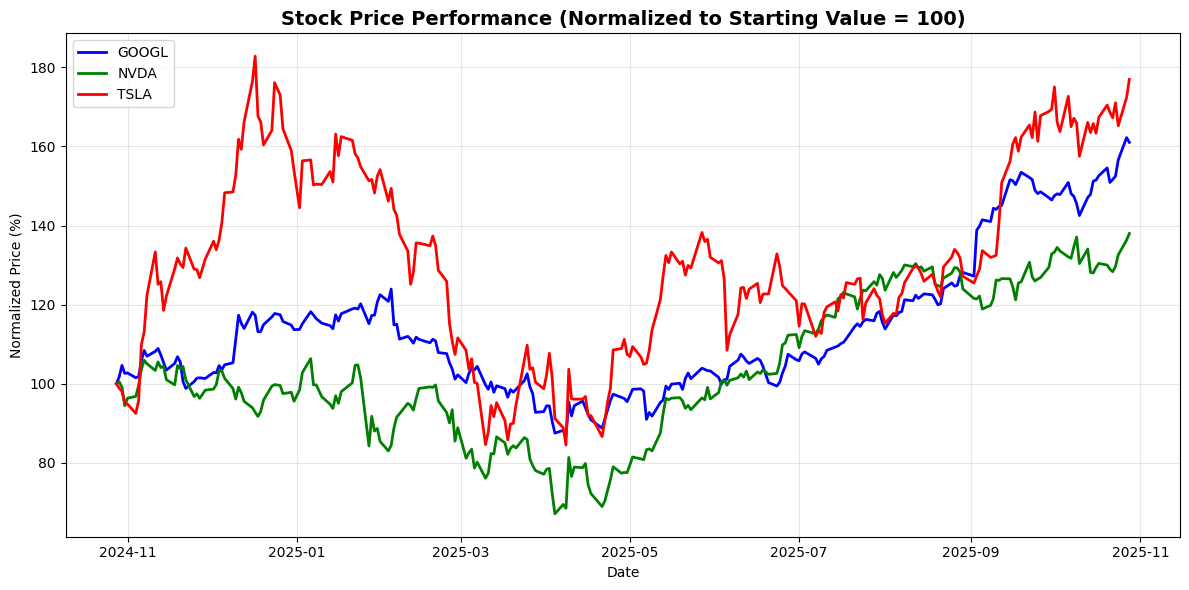


--- Stock Fundamentals Summary ---

NVDA:
  Time Period: 2024-10-28 to 2025-10-28
  Trading Days: 251
  Missing Values: 0
  Price Range: $94.30 - $193.85 ($99.55 spread)
  Starting Price: $140.48
  Ending Price: $193.85
  Total Return: +37.99%
  Daily Volatility: 0.0311

TSLA:
  Time Period: 2024-10-28 to 2025-10-28
  Trading Days: 251
  Missing Values: 0
  Price Range: $221.86 - $479.86 ($258.00 spread)
  Starting Price: $262.51
  Ending Price: $464.47
  Total Return: +76.93%
  Daily Volatility: 0.0427

GOOGL:
  Time Period: 2024-10-28 to 2025-10-28
  Trading Days: 251
  Missing Values: 0
  Price Range: $144.40 - $269.27 ($124.87 spread)
  Starting Price: $165.99
  Ending Price: $267.26
  Total Return: +61.01%
  Daily Volatility: 0.0206


In [365]:
pivot_data = stock_data_raw.pivot(columns='ticker', values='Close')
normalized_pivot = (pivot_data / pivot_data.iloc[0]) * 100

plt.figure(figsize=(12, 6))
colors = {'NVDA': 'green', 'TSLA': 'red', 'GOOGL': 'blue'}
for ticker in normalized_pivot.columns:
    plt.plot(normalized_pivot.index, normalized_pivot[ticker], 
             label=ticker, linewidth=2, color=colors[ticker])

plt.title('Stock Price Performance (Normalized to Starting Value = 100)', fontsize=14, fontweight='bold')
plt.ylabel('Normalized Price (%)')
plt.xlabel('Date')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# Display comprehensive statistics for each stock
print("\n--- Stock Fundamentals Summary ---")
for ticker in stock_data_raw['ticker'].unique():
    ticker_data = stock_data_raw[stock_data_raw['ticker'] == ticker]
    
    # Key metrics
    price_range = ticker_data['Close'].max() - ticker_data['Close'].min()
    volatility = ticker_data['Close'].pct_change().std()
    total_return = ((ticker_data['Close'].iloc[-1] - ticker_data['Close'].iloc[0]) / ticker_data['Close'].iloc[0]) * 100
    avg_volume = ticker_data['Volume'].mean()
    
    print(f"\n{ticker}:")
    print(f"  Time Period: {ticker_data.index.min().strftime('%Y-%m-%d')} to {ticker_data.index.max().strftime('%Y-%m-%d')}")
    print(f"  Trading Days: {len(ticker_data)}")
    print(f"  Missing Values: {ticker_data.isnull().sum().sum()}")
    print(f"  Price Range: ${ticker_data['Close'].min():.2f} - ${ticker_data['Close'].max():.2f} (${price_range:.2f} spread)")
    print(f"  Starting Price: ${ticker_data['Close'].iloc[0]:.2f}")
    print(f"  Ending Price: ${ticker_data['Close'].iloc[-1]:.2f}")
    print(f"  Total Return: {total_return:+.2f}%")
    print(f"  Daily Volatility: {volatility:.4f}")

**Initial Observations:**

- **Bullish Market Context**  
  All three stocks showed strong positive returns (+38% to +77%) over the analysis period, indicating a generally bullish market environment for technology stocks.

- **Volatility Comparison**  
  The normalized plot clearly shows the different volatility profiles, with TSLA exhibiting the largest swings (4.27% daily volatility) and GOOGL appearing most stable (2.06% daily volatility), confirming our initial stock selection rationale.

- **Performance Divergence**  
  The stocks show distinct performance patterns over the year, with significant divergence in returns (TSLA +77% vs NVDA +38%). This variation is ideal for testing our hypothesis, as we have different "signal" strengths to analyze.

- **Data Quality**  
  All three stocks show complete data with no missing values and consistent trading days, providing a solid foundation for analysis.

#### 4.3.2 Reddit Data Composition & Quality

Next, we explore the structure and distribution of the Reddit data. This helps understand the volume, source, and potential quality issues of our sentiment data.

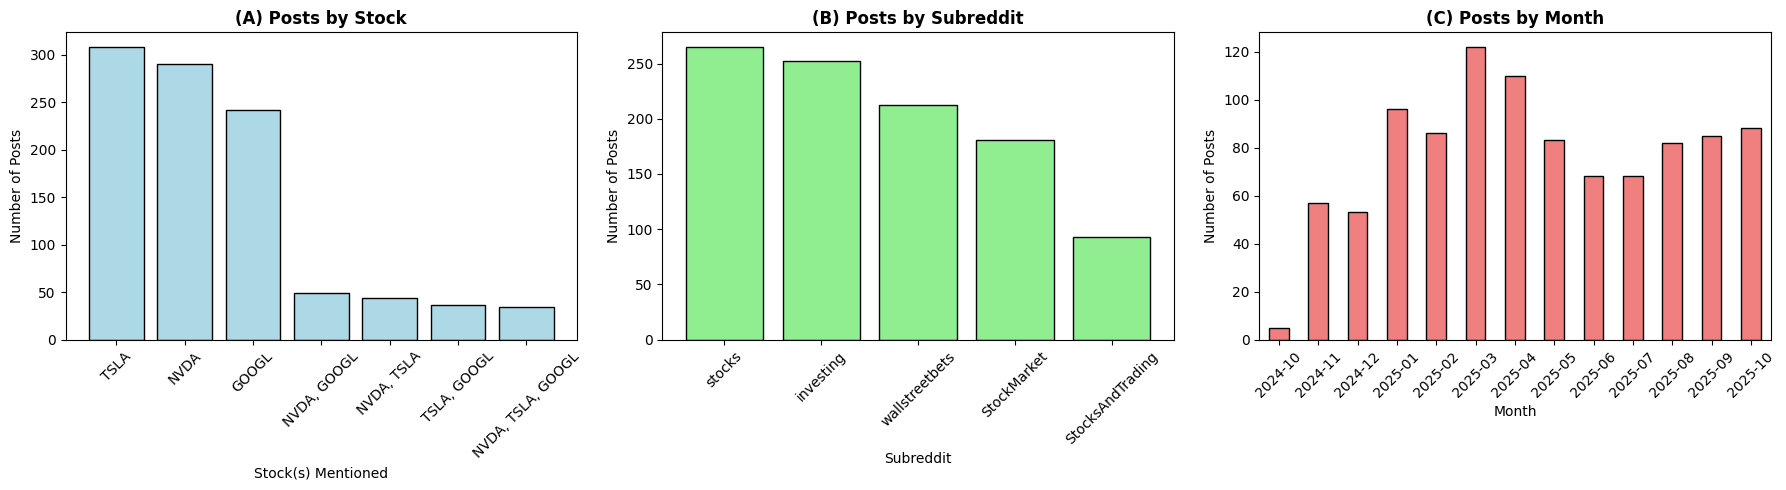

--- General Statistics ---
   Total Posts Collected: 1003
   Date Range: 2024-10-29 to 2025-10-28
   Posts with Empty Content: 165 (16.5%)

--- Posts by Stock Analysis (A) ---
   Single-stock posts: 840 (83.7%)
   Multi-stock posts: 163 (16.3%)

--- Posts by Subreddit Analysis (B) ---
   Avg posts per subreddit: 200.60
   Skewness: -0.732
   Most active subreddit: r/stocks (265 posts)
   Least active subreddit: r/StocksAndTrading (93 posts)

--- Posts by Month Analysis (C) ---
   Avg posts per month: 77.15
   Skewness: -0.936
   Month with most posts: 2025-03 (122 posts)
   Month with fewest posts: 2024-10 (5 posts)


In [366]:
# Create a new figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Raw post distribution by stock
stock_counts = reddit_posts_raw['stock'].value_counts()
axes[0].bar(stock_counts.index, stock_counts.values, color='lightblue', edgecolor='black')
axes[0].set_title('(A) Posts by Stock', fontweight='bold')
axes[0].set_xlabel('Stock(s) Mentioned')
axes[0].set_ylabel('Number of Posts')
axes[0].tick_params(axis='x', rotation=45)

# Plot 2: Posts by subreddit
subreddit_counts = reddit_posts_raw['subreddit'].value_counts()
axes[1].bar(subreddit_counts.index, subreddit_counts.values, color='lightgreen', edgecolor='black')
axes[1].set_title('(B) Posts by Subreddit', fontweight='bold')
axes[1].set_xlabel('Subreddit')
axes[1].set_ylabel('Number of Posts')
axes[1].tick_params(axis='x', rotation=45)

# Plot 3: Posts per month
month_counts = reddit_posts_raw['datetime'].dt.to_period('M').value_counts().sort_index()
month_counts.plot(kind='bar', ax=axes[2], color='lightcoral', edgecolor='black')
axes[2].set_title('(C) Posts by Month', fontweight='bold')
axes[2].set_xlabel('Month')
axes[2].set_ylabel('Number of Posts')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Text-based statistics (unchanged, just remove the subreddit part)
print("--- General Statistics ---")
print(f"   Total Posts Collected: {len(reddit_posts_raw)}")
print(f"   Date Range: {reddit_posts_raw['datetime'].min().strftime('%Y-%m-%d')} to {reddit_posts_raw['datetime'].max().strftime('%Y-%m-%d')}")
print(f"   Posts with Empty Content: {reddit_posts_raw['content'].isna().sum()} ({reddit_posts_raw['content'].isna().sum()/len(reddit_posts)*100:.1f}%)")

print("\n--- Posts by Stock Analysis (A) ---")
single_stock_posts = sum(1 for stock in reddit_posts_raw['stock'] if ', ' not in stock)
multi_stock_posts = len(reddit_posts_raw) - single_stock_posts
print(f"   Single-stock posts: {single_stock_posts} ({single_stock_posts/len(reddit_posts_raw)*100:.1f}%)")
print(f"   Multi-stock posts: {multi_stock_posts} ({multi_stock_posts/len(reddit_posts_raw)*100:.1f}%)")

print("\n--- Posts by Subreddit Analysis (B) ---")
print(f"   Avg posts per subreddit: {(len(reddit_posts_raw) / len(subreddit_counts)):.2f}")
print(f"   Skewness: {skew(subreddit_counts.values):.3f}")
print(f"   Most active subreddit: r/{subreddit_counts.index[0]} ({subreddit_counts.iloc[0]} posts)")
print(f"   Least active subreddit: r/{subreddit_counts.index[-1]} ({subreddit_counts.iloc[-1]} posts)")

print("\n--- Posts by Month Analysis (C) ---")
print(f"   Avg posts per month: {(len(reddit_posts_raw) / len(month_counts)):.2f}")
print(f"   Skewness: {skew(month_counts.values):.3f}")
print(f"   Month with most posts: {posts_per_month.idxmax()} ({posts_per_month.max()} posts)")
print(f"   Month with fewest posts: {posts_per_month.idxmin()} ({posts_per_month.min()} posts)")

**Identified Data Quality Issues:**

1. **Multi-Stock Posts**  
   16.3% of posts (163/1003) mention multiple stocks.

2. **Subreddit Skew**  
   Post distribution across subreddits is moderately skewed, with r/stocks (265 posts) being most active and r/StocksAndTrading (93 posts) least active.

3. **Temporal Skew**  
   Post volume per month is moderately skewed, with October 2024 having only 5 posts and March 2025 having 122 posts.

4. **Content Gaps**  
   16.5% of posts lack body content, relying solely on titles for sentiment.

*These issues will be addressed in the Data Cleaning section below.*

#### 4.3.3 Temporal Alignment Check

Finally, we verify that our stock price and Reddit sentiment data cover overlapping time periods, which is essential for a valid correlation analysis.

In [367]:
stock_start = min(data.index.min() for data in stock_data.values())
stock_end = max(data.index.max() for data in stock_data.values())

if not reddit_posts_raw.empty:
    print("=== TEMPORAL ALIGNMENT CHECK ===\n")

    overlap_start = max(stock_start, reddit_start)
    overlap_end = min(stock_end, reddit_end)
    overlap_days = (overlap_end - overlap_start).days + 1
    
    print("COVERAGE SUMMARY")
    print(f"Stock Data:      {stock_start.strftime('%Y-%m-%d')} to {stock_end.strftime('%Y-%m-%d')} ({len(stock_data['NVDA'])} trading days)")
    print(f"Reddit Data:     {reddit_start.strftime('%Y-%m-%d')} to {reddit_end.strftime('%Y-%m-%d')}")
    print(f"Overlap Period:  {overlap_start.strftime('%Y-%m-%d')} to {overlap_end.strftime('%Y-%m-%d')}")
    print(f"Overlap Duration: {overlap_days} days ({overlap_days/7:.1f} weeks)")
    
    # Calculate coverage metrics
    total_possible_days = (max(stock_end, reddit_end) - min(stock_start, reddit_start)).days + 1
    coverage_percentage = (overlap_days / total_possible_days) * 100
    
    print("\nALIGNMENT METRICS")
    print(f"Temporal Coverage: {coverage_percentage:.1f}% of total period")
else:
    print("No Reddit data available for alignment check")

=== TEMPORAL ALIGNMENT CHECK ===

COVERAGE SUMMARY
Stock Data:      2024-10-28 to 2025-10-28 (251 trading days)
Reddit Data:     2024-10-29 to 2025-10-28
Overlap Period:  2024-10-29 to 2025-10-28
Overlap Duration: 364 days (52.0 weeks)

ALIGNMENT METRICS
Temporal Coverage: 99.5% of total period


**Alignment Assessment:**

- **Extensive Temporal Overlap**  
  364 days of overlapping data provides a solid foundation for weekly analysis.

- **Compatible with Weekly Methodology**  
  The date ranges contain sufficient data to extract 50-52 complete weeks for our Friday-to-Friday analysis approach (accounting for potential incomplete first/last weeks).

- **Conclusion**  
  The raw datasets show extensive temporal overlap suitable for weekly aggregation. The exact number of complete Friday-to-Friday weeks will be confirmed during the feature engineering phase.

## 5. Data Preprocessing & Feature Engineering

### 5.1 Addressing Data Quality Issues

Based on the initial inspection, the following data quality issues were identified and will be addressed:

* **Issue 1: Multi-Stock Posts**  
  Finding: 163 posts (16%) mention multiple stocks, creating ambiguous sentiment attribution.  
  Solution: These posts will be duplicated for each mentioned stock to ensure clean stock-specific analysis.  
  Limitation: This approach assumes sentiment applies equally to all mentioned stocks, which may not reflect nuanced discussions where stocks are mentioned with different sentiment valences (e.g., "I love NVDA but hate TSLA"). This is a noted constraint of our sentiment aggregation methodology.

* **Issue 2: Empty Content**  
  Finding: 165 posts (16%) have empty content.  
  Solution: The post title will be used as the primary content for sentiment analysis, as titles typically contain the core sentiment.

* **Issue 3: Temporal Volatility in Post Volume**  
  Finding: Post volume shows moderate volatility, with particularly low volume in October 2024 (5 posts).  
  Solution: Weekly aggregation will smooth this volatility. The impact of low-volume periods on weekly sentiment averages will be considered during analysis.

### 5.2 Data Cleaning

In [368]:
# Create a copy for processing
reddit_posts_clean = reddit_posts_raw.copy()
print(f"Initial dataset: {len(reddit_posts_clean)} posts")

# 1. Handle Multi-Stock Posts
print("\n1. Processing multi-stock posts...")

expanded_posts = []
for i, row in reddit_posts_clean.iterrows():
    if ', ' in row['stock']:
        # Split and clean stock symbols
        multiple_stocks = [s.strip() for s in row['stock'].split(', ')]
        for stock in multiple_stocks:
            new_row = row.copy()
            new_row['stock'] = stock
            new_row['was_multi_stock'] = True  # Flag for tracking
            expanded_posts.append(new_row)
    else:
        row['was_multi_stock'] = False  # Flag for tracking
        expanded_posts.append(row)

reddit_posts_clean = pd.DataFrame(expanded_posts).reset_index(drop=True)
print(f"   After expansion: {len(reddit_posts_clean)} individual stock-mentions")

# 2. Handle Empty Content
print("\n2. Handling empty content...")

reddit_posts_clean['content_clean'] = reddit_posts_clean['content'].fillna('')
reddit_posts_clean['text_for_analysis'] = reddit_posts_clean['title'] + ' ' + reddit_posts_clean['content_clean']
reddit_posts_clean['text_for_analysis'] = reddit_posts_clean['text_for_analysis'].str.strip()

# Check for completely empty text
empty_text_after = (reddit_posts_clean['text_for_analysis'].str.len() == 0).sum()
print(f"   Posts with no text after cleaning: {empty_text_after}")

print(f"\nData cleaning completed")

Initial dataset: 1003 posts

1. Processing multi-stock posts...
   After expansion: 1200 individual stock-mentions

2. Handling empty content...
   Posts with no text after cleaning: 0

Data cleaning completed


#### 5.2.1 Data Cleaning Validation

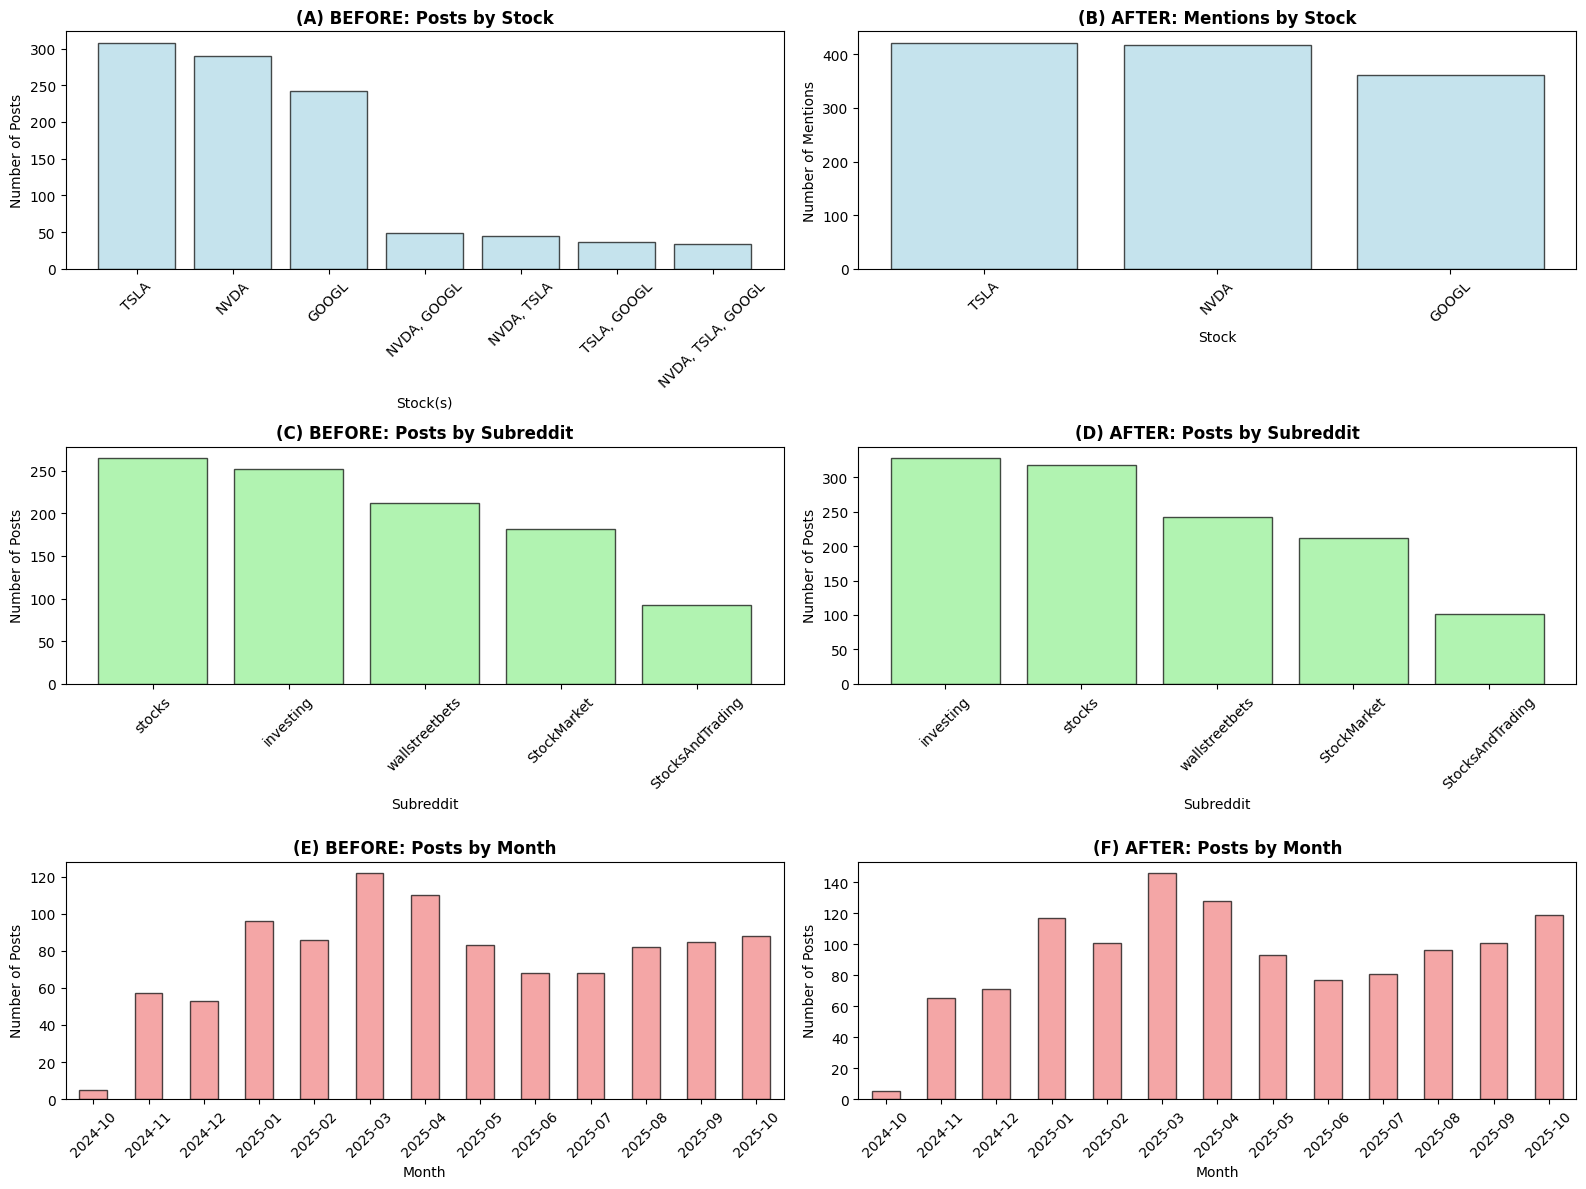

=== DISTRIBUTION CHANGES ===

STOCK DISTRIBUTION (A/B):
   Posts:  1200
     (BEFORE: 1003 posts, 163 multi-stock posts)
   -> 197 posts increase

SUBREDDIT DISTRIBUTION (C/D):
   Avg posts per Subreddit: 240.00
     (BEFORE 200.60)
   Skewness: -0.551
     (BEFORE: -0.732)
   Most active: r/investing (328 posts)
     (BEFORE: r/stocks (265 posts))
   Least active: r/StocksAndTrading (102 posts)
     (BEFORE: r/StocksAndTrading (93 posts))

TEMPORAL DISTRIBUTION (E/F):
   Avg posts per Month: 92.31
     (BEFORE 77.15)
   Skewness: -0.928
     (BEFORE: -0.936)
   Month with most posts: 2025-03 (146 posts)
     (BEFORE: 2025-03 (122 posts)
   Month with fewest posts: 2024-10 (5 posts)
     (BEFORE: 2024-10 (5 posts))


In [373]:
# Create comparison figure - 3 rows, 2 columns
fig, axes = plt.subplots(3, 2, figsize=(16, 12))

# Calculate all statistics first
stock_counts_before = reddit_posts_raw['stock'].value_counts()
stock_counts_after = reddit_posts_clean['stock'].value_counts()
subreddit_counts_before = reddit_posts_raw['subreddit'].value_counts()
subreddit_counts_after = reddit_posts_clean['subreddit'].value_counts()
month_counts_before = reddit_posts_raw['datetime'].dt.to_period('M').value_counts().sort_index()
month_counts_after = reddit_posts_clean['datetime'].dt.to_period('M').value_counts().sort_index()

# Row 1: Stock Distribution
# Left: BEFORE
axes[0,0].bar(stock_counts_before.index, stock_counts_before.values, color='lightblue', edgecolor='black', alpha=0.7)
axes[0,0].set_title('(A) BEFORE: Posts by Stock', fontweight='bold')
axes[0,0].set_xlabel('Stock(s)')
axes[0,0].set_ylabel('Number of Posts')
axes[0,0].tick_params(axis='x', rotation=45)

# Right: AFTER
axes[0,1].bar(stock_counts_after.index, cleaned_stock_counts.values, color='lightblue', edgecolor='black', alpha=0.7)
axes[0,1].set_title('(B) AFTER: Mentions by Stock', fontweight='bold')
axes[0,1].set_xlabel('Stock')
axes[0,1].set_ylabel('Number of Mentions')
axes[0,1].tick_params(axis='x', rotation=45)

# Row 2: Subreddit Distribution
# Left: BEFORE
axes[1,0].bar(subreddit_counts_before.index, subreddit_counts_before.values, color='lightgreen', edgecolor='black', alpha=0.7)
axes[1,0].set_title('(C) BEFORE: Posts by Subreddit', fontweight='bold')
axes[1,0].set_xlabel('Subreddit')
axes[1,0].set_ylabel('Number of Posts')
axes[1,0].tick_params(axis='x', rotation=45)

# Right: AFTER
axes[1,1].bar(subreddit_counts_after.index, subreddit_counts_after.values, color='lightgreen', edgecolor='black', alpha=0.7)
axes[1,1].set_title('(D) AFTER: Posts by Subreddit', fontweight='bold')
axes[1,1].set_xlabel('Subreddit')
axes[1,1].set_ylabel('Number of Posts')
axes[1,1].tick_params(axis='x', rotation=45)

# Row 3: Temporal Distribution
# Left: BEFORE
month_counts_before.plot(kind='bar', ax=axes[2,0], color='lightcoral', edgecolor='black', alpha=0.7)
axes[2,0].set_title('(E) BEFORE: Posts by Month', fontweight='bold')
axes[2,0].set_xlabel('Month')
axes[2,0].set_ylabel('Number of Posts')
axes[2,0].tick_params(axis='x', rotation=45)

# Right: AFTER
month_counts_after.plot(kind='bar', ax=axes[2,1], color='lightcoral', edgecolor='black', alpha=0.7)
axes[2,1].set_title('(F) AFTER: Posts by Month', fontweight='bold')
axes[2,1].set_xlabel('Month')
axes[2,1].set_ylabel('Number of Posts')
axes[2,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Distribution changes below each plot category
print("=== DISTRIBUTION CHANGES ===\n")

print("STOCK DISTRIBUTION (A/B):")
multi_stock_before = len([s for s in reddit_posts_raw['stock'] if ', ' in s])
print(f"   Posts:  {len(reddit_posts_clean)}")
print(f"     (BEFORE: {len(reddit_posts_raw)} posts, {multi_stock_before} multi-stock posts)")
print(f"   -> {len(reddit_posts_clean) - len(reddit_posts_raw)} posts increase")

print("\nSUBREDDIT DISTRIBUTION (C/D):")
print(f"   Avg posts per Subreddit: {(len(reddit_posts_clean) / len(subreddit_counts_after)):.2f}")
print(f"     (BEFORE {(len(reddit_posts_raw) / len(subreddit_counts_before)):.2f})")
print(f"   Skewness: {skew(subreddit_counts_after.values):.3f}")
print(f"     (BEFORE: {skew(subreddit_counts_before.values):.3f})")
print(f"   Most active: r/{subreddit_counts_after.index[0]} ({subreddit_counts_after.iloc[0]} posts)")
print(f"     (BEFORE: r/{subreddit_counts_before.index[0]} ({subreddit_counts_before.iloc[0]} posts))")
print(f"   Least active: r/{subreddit_counts_after.index[-1]} ({subreddit_counts_after.iloc[-1]} posts)")
print(f"     (BEFORE: r/{subreddit_counts_before.index[-1]} ({subreddit_counts_before.iloc[-1]} posts))")

print("\nTEMPORAL DISTRIBUTION (E/F):")
print(f"   Avg posts per Month: {(len(reddit_posts_clean) / len(month_counts_after)):.2f}")
print(f"     (BEFORE {(len(reddit_posts_raw) / len(month_counts_before)):.2f})")
print(f"   Skewness: {skew(month_counts_after.values):.3f}")
print(f"     (BEFORE: {skew(month_counts_before.values):.3f})")
print(f"   Month with most posts: {month_counts_after.idxmax()} ({month_counts_after.max()} posts)")
print(f"     (BEFORE: {month_counts_before.idxmax()} ({month_counts_before.max()} posts)")
print(f"   Month with fewest posts: {month_counts_after.idxmin()} ({month_counts_after.min()} posts)")
print(f"     (BEFORE: {month_counts_before.idxmin()} ({month_counts_before.min()} posts))")

#### Data Cleaning Validation Assessment

- **Multi-Stock Issue Resolved**  
  The increase in posts (197 additional posts) confirms successful explosion of multi-stock posts. Each row now contains exactly one stock for clean analysis.

- **Data Integrity Maintained**  
  The consistent temporal pattern (same peak/valley months) and similar skewness values show that cleaning preserved the underlying data structure while resolving the multi-stock ambiguity.

- **Notable Shift in Subreddit Ranking**  
  The most active subreddit changed from r/stocks to r/investing after cleaning. This suggests r/investing had more multi-stock discussions, which is reasonable given its broader investment focus compared to r/stocks' single-stock discussions.

### 5.3 Feature Engineering

This section creates the analytical features needed for correlation analysis:

**A. Post-Level Feature Engineering**
- Add sentiment scores to each post (`textblob_score`, `vader_score`, `combined_score`)
- Add categorical `combined_sentiment_label` based on the combined score (positive/neutral/negative) 
- Add temporal feature `week_ending` (Friday-based) to each post

**B. Weekly Aggregation**  
- Calculate **weekly percentage returns** for each stock (Friday-to-Friday)
- **Drop incomplete weeks** (no prior Friday for returns / Firday outside of stock date range)
- Aggregate post-level sentiment to **weekly means** per stock
- **Align** weekly sentiment scores with weekly stock returns using Friday week-ending dates

#### 5.3.1 Post-Level Feature Engineering

In [374]:
print("Starting feature engineering...")

# Initialize sentiment analyzers
vader_analyzer = SentimentIntensityAnalyzer()
print("✓ Sentiment analyzers initialized")

def analyze_sentiment(text):
    """Sentiment analysis using TextBlob and VADER."""
    # Handle missing/invalid text robustly
    if not text or pd.isna(text) or text in ['[removed]', '[deleted]', '']:
        return {
            'textblob_score': 0.0,
            'vader_score': 0.0,
            'combined_score': 0.0,
            'combined_sentiment_label': 'neutral',
        }
    
    text = str(text).strip()
    
    # VADER sentiment analysis
    try:
        vader_compound = vader_analyzer.polarity_scores(text)["compound"]
    except Exception as e:
        print(f"VADER analysis failed for text: {text[:100]}... Error: {e}")
        vader_compound = 0.0
    
    # TextBlob sentiment analysis
    try:
        blob = TextBlob(text)
        textblob_polarity = blob.sentiment.polarity
    except Exception as e:
        print(f"TextBlob analysis failed for text: {text[:100]}... Error: {e}")
        textblob_polarity = 0.0
    
    # Combined score (equal weighting)
    combined_score = (vader_compound + textblob_polarity) / 2
    
    # Research-based threshold selection
    # Based on common NLP practice: > 0.05 for positive, < -0.05 for negative
    # These thresholds provide clear separation while avoiding over-sensitivity to noise
    if combined_score > 0.05:
        sentiment_label = 'positive'
    elif combined_score < -0.05:
        sentiment_label = 'negative'
    else:
        sentiment_label = 'neutral'
        
    return {
        'textblob_score': textblob_polarity,
        'vader_score': vader_compound,
        'combined_score': combined_score,
        'combined_sentiment_label': sentiment_label,
    }

print("\nApplying sentiment analysis...")

# Apply sentiment analysis and expand results into separate columns
sentiment_results = reddit_posts_clean['text_for_analysis'].apply(analyze_sentiment)
sentiment_df = pd.json_normalize(sentiment_results)
reddit_posts_sentiment = reddit_posts_clean.assign(**sentiment_df.to_dict('series'))

# Validation
print("✓ Sentiment analysis completed\n")
print(f"   Posts with Textblob scores: {len(reddit_posts_sentiment['textblob_score'])}/{len(reddit_posts_clean)}")
print(f"   Posts with VADER scores: {len(reddit_posts_sentiment['vader_score'])}/{len(reddit_posts_clean)}")
print(f"   Posts with Combined scores: {len(reddit_posts_sentiment['combined_score'])}/{len(reddit_posts_clean)}")

# Add Temporal Feature for Weekly Analysis
print("\nAdding Friday-based week_ending to each post...")

reddit_posts_sentiment['week_ending'] = reddit_posts_sentiment['datetime'].dt.to_period('W-FRI').dt.end_time.dt.date

print(f"   Added week_ending for {reddit_posts_sentiment['week_ending'].nunique()} unique weeks")
print(f"   Date range: {reddit_range_start} to {reddit_range_end}")

Starting feature engineering...
✓ Sentiment analyzers initialized

Applying sentiment analysis...
✓ Sentiment analysis completed

   Posts with Textblob scores: 1200/1200
   Posts with VADER scores: 1200/1200
   Posts with Combined scores: 1200/1200

Adding Friday-based week_ending to each post...
   Added week_ending for 53 unique weeks
   Date range: 2024-11-01 to 2025-10-31


#### 5.3.2 Weekly Aggregation

In [375]:
# --- Stock Returns Calculation ---
print("\nCalculating stock returns...")

def calculate_weekly_stock_returns(stocks_df):
    """Calculate weekly stock returns for correlation analysis"""
    weekly_returns_list = []
    
    for ticker in stocks_df['ticker'].unique():
        # Filter data for this ticker
        ticker_data = stocks_df[stocks_df['ticker'] == ticker].copy()
        
        # Weekly returns (Friday to Friday)
        weekly_data = ticker_data.resample('W-FRI').last()
        weekly_data['weekly_return'] = weekly_data['Close'].pct_change()
        weekly_data['week_ending'] = weekly_data.index.date
        weekly_data['ticker'] = ticker  # Ensure ticker column is preserved

        # Remove first week if no prior closing (no weekly_return value)
        weekly_data = weekly_data.dropna()
        
        # Remove last week if it is incomplete (last date is not a Friday)
        last_week_ending_date = weekly_data.index[-1]
        last_actual_date = ticker_data.index[-1]
        
        if last_week_ending_date > last_actual_date:
            weekly_data = weekly_data.iloc[:-1]  # Remove last week
        
        weekly_returns_list.append(weekly_data)
        print(f"  {ticker}: {len(weekly_data)} complete weeks")
        print(f"    {weekly_data['week_ending'].min()} - {weekly_data['week_ending'].max()}")
    
    # Combine all tickers into one DataFrame
    combined_returns = pd.concat(weekly_returns_list, ignore_index=False)
    return combined_returns

# Calculate returns for all stocks
stock_returns_weekly = calculate_weekly_stock_returns(stock_data_raw)
print("✓ Stock returns calculated")


# --- Aggregate Sentiment to Weekly Averages ---
print("\nAggregating weekly sentiment averages per stock...")
def aggregate_weekly_stock_sentiment(sentiment_df, returns_df):
    """Process all stocks at once using vectorized operations"""
    
    # Get valid stock-week combinations directly from returns DataFrame
    valid_combinations = returns_df[['ticker', 'week_ending']].drop_duplicates()
    valid_combinations = valid_combinations.rename(columns={'ticker': 'stock'})
    
    # Single merge operation for all stocks
    filtered_sentiment = sentiment_df.merge(valid_combinations, on=['stock', 'week_ending'])
    
    # Single aggregation for all stocks
    weekly_sentiment = filtered_sentiment.groupby(['stock', 'week_ending']).agg({
        'vader_score': 'mean',
        'textblob_score': 'mean', 
        'combined_score': 'mean',
        'id': 'count'
    }).reset_index()
    
    weekly_sentiment = weekly_sentiment.rename(columns={'id': 'post_count'})
    
    # Recalculate sentiment_label based on weekly combined_score mean
    weekly_sentiment['combined_sentiment_label'] = weekly_sentiment['combined_score'].apply(
        lambda score: 'positive' if score > 0.05 else 'negative' if score < -0.05 else 'neutral'
    )

    return weekly_sentiment

reddit_sentiment_weekly = aggregate_weekly_stock_sentiment(reddit_posts_sentiment, stock_returns_weekly)
print(f"✓ Weekly sentiment aggregation completed")
print(f"   Total aligned weekly observations: {len(reddit_sentiment_weekly)}")
print(f"   Unique weeks: {reddit_sentiment_weekly['week_ending'].nunique()}")


Calculating stock returns...
  NVDA: 51 complete weeks
    2024-11-08 - 2025-10-24
  TSLA: 51 complete weeks
    2024-11-08 - 2025-10-24
  GOOGL: 51 complete weeks
    2024-11-08 - 2025-10-24
✓ Stock returns calculated

Aggregating weekly sentiment averages per stock...
✓ Weekly sentiment aggregation completed
   Total aligned weekly observations: 153
   Unique weeks: 51


### 5.4 Weekly Data Validation

Before merging, we validate both weekly datasets using these quality thresholds:

**Quality Thresholds:**
- **Reliable sentiment**: ≥3 posts per week for stable averages  
- **No data gaps**: Continuous weekly observations
- **Adequate alignment**: Sufficient overlapping weeks for correlation analysis

The validation below assesses these criteria and identifies any reliability concerns.

#### 5.4.1 Weekly Stock Returns Validation
Validate stock returns data for completeness, distribution, and temporal coverage.

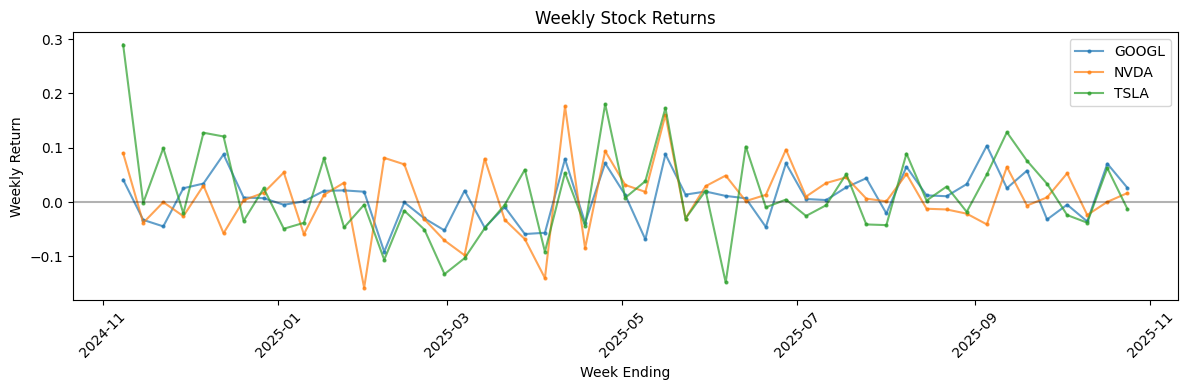


=== STOCK RETURNS VALIDATION ===
1. Returns Data Completeness:
NVDA
  Full Weeks: 51
  Missing Returns: 0
  Date Range: 2024-11-08 - 2025-10-24
TSLA
  Full Weeks: 51
  Missing Returns: 0
  Date Range: 2024-11-08 - 2025-10-24
GOOGL
  Full Weeks: 51
  Missing Returns: 0
  Date Range: 2024-11-08 - 2025-10-24


In [378]:
# Using pivot for easier plotting
plt.figure(figsize=(12, 4))
pivot_returns = stock_returns_weekly.pivot(index='week_ending', columns='ticker', values='weekly_return')

for ticker in pivot_returns.columns:
    plt.plot(pivot_returns.index, pivot_returns[ticker], marker='o', label=ticker, markersize=2, alpha=0.7)

plt.title('Weekly Stock Returns')
plt.xlabel('Week Ending')
plt.ylabel('Weekly Return')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\n=== STOCK RETURNS VALIDATION ===")

# 1. Basic completeness check
print("1. Returns Data Completeness:")
for ticker in stock_returns_weekly['ticker'].unique():
    ticker_data = stock_returns_weekly[stock_returns_weekly['ticker'] == ticker]
    missing_returns = ticker_data['weekly_return'].isna().sum()
    print(f"{ticker}")
    print(f"  Full Weeks: {len(ticker_data)}")
    print(f"  Missing Returns: {missing_returns}")
    print(f"  Date Range: {ticker_data['week_ending'].min()} - {ticker_data['week_ending'].max()}")

#### Weekly Stock Returns Validation Assessment:

- All three stocks have weekly returns for 51 weeks with no gaps
- Date range: 2024-11-08 to 2025-10-24
- No missing returns in any stock-week combination

#### 5.4.2 Weekly Reddit Sentiment Validation

Validate Reddit post coverage for gaps, low-volume weeks, and temporal coverage.

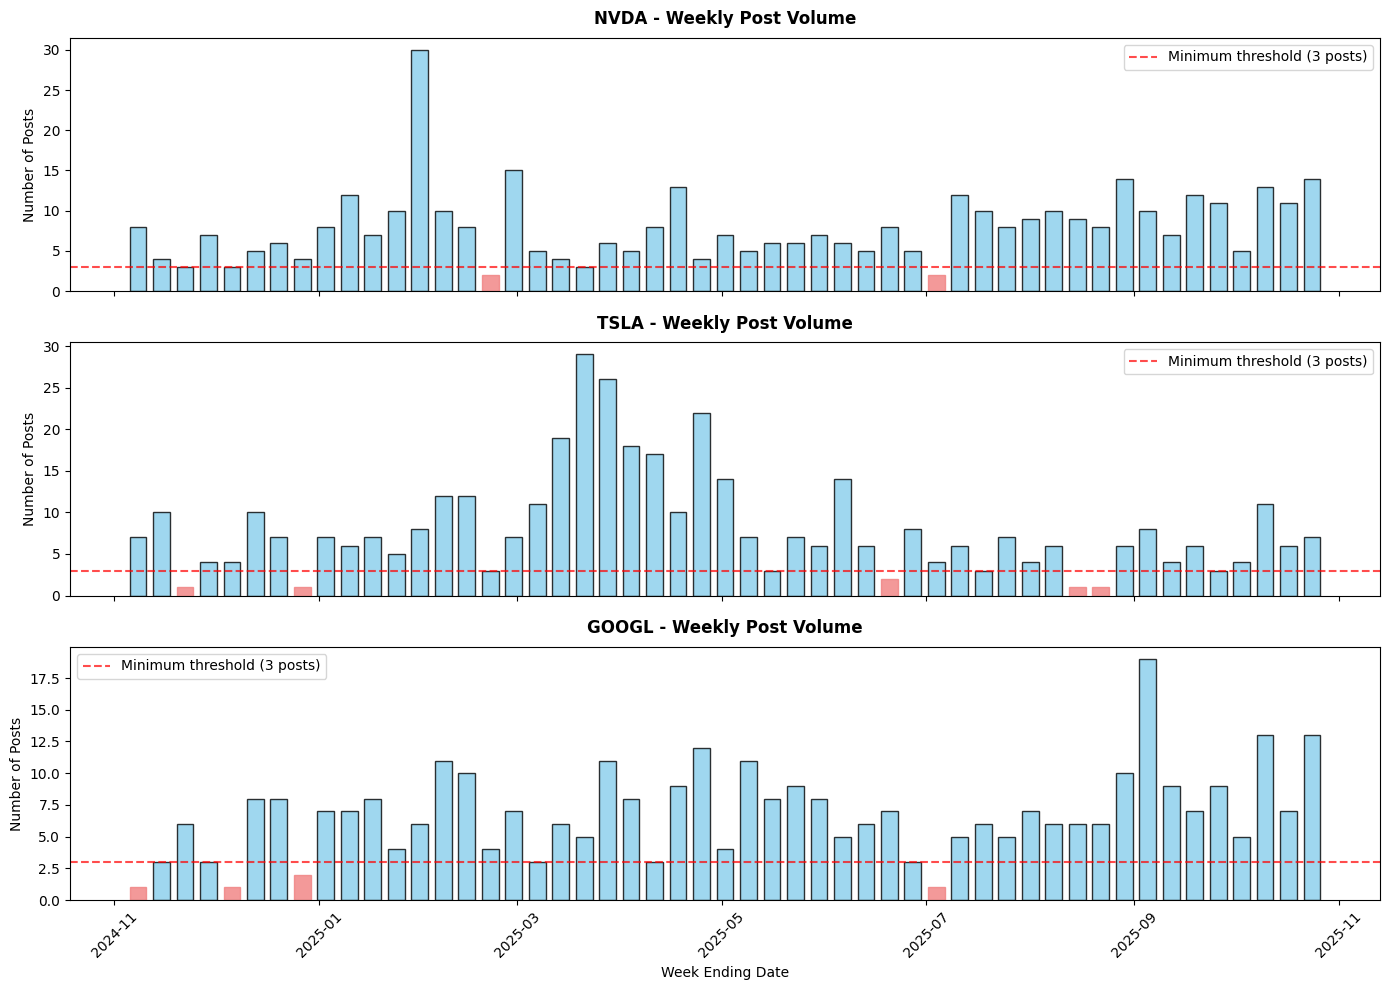


=== WEEKLY POST VOLUME SUMMARY ===
NVDA:
  Total weeks: 51
  Total number of posts: 410
  Weeks with <3 posts: 2 (3.92%)
  Weeks with 0 posts: 0
  Average posts/week: 8.0
TSLA:
  Total weeks: 51
  Total number of posts: 417
  Weeks with <3 posts: 5 (9.80%)
  Weeks with 0 posts: 0
  Average posts/week: 8.2
GOOGL:
  Total weeks: 51
  Total number of posts: 348
  Weeks with <3 posts: 4 (7.84%)
  Weeks with 0 posts: 0
  Average posts/week: 6.8

ALL
  Total weeks: 153
  Total number of posts: 1175
  Weeks with <3 posts: 11 (7.19%)
  Weeks with 0 posts: 0


In [379]:
# Create 3x1 subplot for weekly post volume by stock
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Get sorted weeks for consistent x-axis
all_weeks = sorted(reddit_sentiment_weekly['week_ending'].unique())

for idx, stock in enumerate(['NVDA', 'TSLA', 'GOOGL']):
    # Get data for this stock
    single_stock_data = reddit_sentiment_weekly[reddit_sentiment_weekly['stock'] == stock].sort_values('week_ending')
    
    # Create bar positions and widths
    weeks = single_stock_data['week_ending']
    posts = single_stock_data['post_count']
    
    # Create bar chart
    bars = axes[idx].bar(weeks, posts, color='skyblue', edgecolor='black', alpha=0.8, width=5)
    
    # Highlight low-volume weeks (<3 posts) in red
    for i, (week, count) in enumerate(zip(weeks, posts)):
        if count < 3:
            bars[i].set_color('lightcoral')
    
    # Customize each subplot
    axes[idx].set_title(f'{stock} - Weekly Post Volume', fontweight='bold', pad=10)
    axes[idx].set_ylabel('Number of Posts')
    axes[idx].axhline(y=3, color='red', linestyle='--', alpha=0.7, label='Minimum threshold (3 posts)')
    axes[idx].legend()
    
    # Format x-axis
    axes[idx].tick_params(axis='x', rotation=45)
    
    # Only show x-axis labels on bottom plot to reduce clutter
    if idx < 2:
        axes[idx].set_xticklabels([])
    else:
        axes[idx].set_xlabel('Week Ending Date')

plt.tight_layout()
plt.show()

# Add summary statistics
print("\n=== WEEKLY POST VOLUME SUMMARY ===")
for stock in ['NVDA', 'TSLA', 'GOOGL']:
    single_stock_data = reddit_sentiment_weekly[reddit_sentiment_weekly['stock'] == stock]
    low_volume = len(single_stock_data[single_stock_data['post_count'] < 3])
    zero_posts = len(single_stock_data[single_stock_data['post_count'] == 0])
    
    print(f"{stock}:")
    print(f"  Total weeks: {len(single_stock_data)}")
    print(f"  Total number of posts: {single_stock_data['post_count'].sum()}")
    print(f"  Weeks with <3 posts: {low_volume} ({low_volume/len(single_stock_data)*100:.2f}%)")
    print(f"  Weeks with 0 posts: {zero_posts}")
    print(f"  Average posts/week: {single_stock_data['post_count'].mean():.1f}")

print("\nALL")
print(f"  Total weeks: {len(reddit_sentiment_weekly)}")
print(f"  Total number of posts: {reddit_sentiment_weekly['post_count'].sum()}")
low_volume_all = len(reddit_sentiment_weekly[reddit_sentiment_weekly['post_count'] < 3])
zero_posts_all = len(reddit_sentiment_weekly[reddit_sentiment_weekly['post_count'] == 0])
print(f"  Weeks with <3 posts: {low_volume_all} ({low_volume_all/len(reddit_sentiment_weekly)*100:.2f}%)")
print(f"  Weeks with 0 posts: {zero_posts_all}")

#### Weekly Reddit Sentiment Validation Assessment

**Reliability**  
- **NVDA**: Excellent coverage with only 3.92% of weeks having low post volume
- **TSLA**: Good coverage though with higher low-volume weeks (9.80%) - sentiment may be noisier
- **GOOGL**: Solid coverage with 7.84% low-volume weeks

**Quality**  
- 92.81% of weeks have adequate post volume (≥3 posts)
- Consistent 51-week coverage across all stocks
- No gaps in temporal coverage

#### 5.4.3 Weekly Alignment Validation

In [380]:
for ticker in stock_returns_weekly['ticker'].unique():
    # Get returns data for this stock
    returns_data = stock_returns_weekly[stock_returns_weekly['ticker'] == ticker]
    returns_weeks = set(returns_data['week_ending'])
    
    # Get sentiment data for this stock
    sentiment_data = reddit_sentiment_weekly[reddit_sentiment_weekly['stock'] == ticker]
    sentiment_weeks = set(sentiment_data['week_ending'])
    
    # Calculate alignment
    overlapping_weeks = returns_weeks & sentiment_weeks
    total_possible_weeks = len(returns_weeks | sentiment_weeks)
    alignment_percentage = (len(overlapping_weeks) / total_possible_weeks) * 100
    
    print(f"\n{ticker}:")
    print(f"  Weekly Returns:    {len(returns_weeks)} weeks, {returns_data['week_ending'].min()} to {returns_data['week_ending'].max()}")
    print(f"  Weekly Sentiment:  {len(sentiment_weeks)} weeks, {sentiment_data['week_ending'].min()} to {sentiment_data['week_ending'].max()}")
    print(f"  Overlap:           {len(overlapping_weeks)} weeks ({alignment_percentage:.1f}% alignment)")
    
    # Show any mismatches
    if len(overlapping_weeks) < len(returns_weeks):
        missing_in_sentiment = returns_weeks - sentiment_weeks
        missing_in_returns = sentiment_weeks - returns_weeks
        if missing_in_sentiment:
            print(f"    Missing in sentiment: {len(missing_in_sentiment)} weeks")
        if missing_in_returns:
            print(f"    Missing in returns: {len(missing_in_returns)} weeks")


NVDA:
  Weekly Returns:    51 weeks, 2024-11-08 to 2025-10-24
  Weekly Sentiment:  51 weeks, 2024-11-08 to 2025-10-24
  Overlap:           51 weeks (100.0% alignment)

TSLA:
  Weekly Returns:    51 weeks, 2024-11-08 to 2025-10-24
  Weekly Sentiment:  51 weeks, 2024-11-08 to 2025-10-24
  Overlap:           51 weeks (100.0% alignment)

GOOGL:
  Weekly Returns:    51 weeks, 2024-11-08 to 2025-10-24
  Weekly Sentiment:  51 weeks, 2024-11-08 to 2025-10-24
  Overlap:           51 weeks (100.0% alignment)


#### Weekly Alignment Validation Assessment

**Temporal Coverage**  
- All three stocks have weekly returns for 51 weeks with no gaps.
   - (2024-11-08 - 2025-10-24)
- All three stocks have sentiment data for 51 weeks with no gaps.
   - (2024-11-08 - 2025-10-24)
    
**Alignment Quality**  
With 92.81% of weeks having adequate post volume (≥3 posts) and consistent 51-week coverage, the dataset provides a robust foundation for correlation analysis.

**Methodological Decision**  
All 51 weeks will be included in the correlation analysis. While weeks with fewer than 3 posts may have noisier sentiment measurements, they represent genuine periods of lower market discussion and provide a complete picture of the relationship over time.

### 5.5 Dataset Merging & Final Validation

This section combines the engineered weekly features into the final analysis dataset:

- **Merge** weekly sentiment scores with weekly stock returns
- **Validate** the merged dataset structure and completeness

#### 5.5.1 Dataset Merging

With both datasets validated and temporally aligned, we now merge the weekly sentiment averages with weekly stock returns to create the final analysis dataset. The merge uses an inner join on `stock` and `week_ending` columns to ensure only complete stock-week pairs are included.

In [381]:
# Prepare the returns data for merging (keep only essential columns)
returns_for_merge = stock_returns_weekly[['ticker', 'week_ending', 'weekly_return']].copy()
returns_for_merge = returns_for_merge.rename(columns={'ticker': 'stock'})

print(f"Returns data for merging: {len(returns_for_merge)} observations")
print(f"Sentiment data for merging: {len(reddit_sentiment_weekly)} observations")

# Merge the datasets
merged_data = reddit_sentiment_weekly.merge(
    returns_for_merge,
    on=['stock', 'week_ending'],
    how='inner'  # Should be perfect match due to previous alignment
)

print(f"✓ Merged dataset created: {len(merged_data)} observations")
print(f"  Stocks: {merged_data['stock'].unique().tolist()}")
print(f"  Weeks: {merged_data['week_ending'].nunique()}")
print(f"  Date range: {merged_data['week_ending'].min()} to {merged_data['week_ending'].max()}")

Returns data for merging: 153 observations
Sentiment data for merging: 153 observations
✓ Merged dataset created: 153 observations
  Stocks: ['GOOGL', 'NVDA', 'TSLA']
  Weeks: 51
  Date range: 2024-11-08 to 2025-10-24


#### 5.5.2 Merged Dataset Validation

After merging, we perform a final validation to ensure the dataset is analysis-ready.  
This checks data integrity, completeness, and confirms the merged dataset meets all quality standards for correlation analysis.

In [424]:
# 1. Basic structure check
print("1. Dataset Structure:")
print(f"   Rows: {len(merged_data)}")
print(f"   Columns: {len(merged_data.columns)}")
print(f"   Shape: {merged_data.shape}")

# 2. Completeness check
print("\n2. Data Completeness:")
print(f"   Missing values:")
for col in merged_data.columns:
    missing = merged_data[col].isna().sum()
    if missing > 0:
        print(f"     ✗ {col}: {missing} missing")
    else:
        print(f"     ✓ {col}: complete")

print("\n3. Data Quality:")
print(f"   Expected observations: {merged_data['stock'].nunique()} stocks × {merged_data['week_ending'].nunique()} weeks = {merged_data['stock'].nunique() * merged_data['week_ending'].nunique()}")
print(f"     Actual observations: {len(merged_data)}")
duplicates = merged_data.duplicated(subset=['stock', 'week_ending']).sum()
print(f"   Duplicate stock-week pairs: {duplicates}")
print(f"   Weeks with <3 posts: {low_volume_weeks} ({low_volume_weeks/len(merged_data)*100:.1f}%)")

1. Dataset Structure:
   Rows: 153
   Columns: 9
   Shape: (153, 9)

2. Data Completeness:
   Missing values:
     ✓ stock: complete
     ✓ week_ending: complete
     ✓ vader_score: complete
     ✓ textblob_score: complete
     ✓ combined_score: complete
     ✓ post_count: complete
     ✓ combined_sentiment_label: complete
     ✓ weekly_return: complete
     ✓ month: complete

3. Data Quality:
   Expected observations: 3 stocks × 51 weeks = 153
     Actual observations: 153
   Duplicate stock-week pairs: 0
   Weeks with <3 posts: 11 (7.2%)


# 6. Exploratory Data Analysis

Before testing our hypothesis about sentiment and returns, we first examine the fundamental characteristics of our key variables. This initial exploration ensures we understand what we're working with and helps identify any data issues that might affect our correlation analysis.

## 6.1 Distribution of Target Variable: Weekly Returns

We begin by analyzing the weekly returns for NVDA, TSLA, and GOOGL — the core metric we're trying to relate to Reddit sentiment. This examination answers basic but crucial questions: How volatile are these stocks? What are their typical weekly movements? Are there extreme values that could distort our results?

The findings here establish the baseline behavior of our dependent variable and inform whether standard correlation methods are appropriate for this dataset.

=== WEEKLY RETURNS DISTRIBUTION ANALYSIS ===


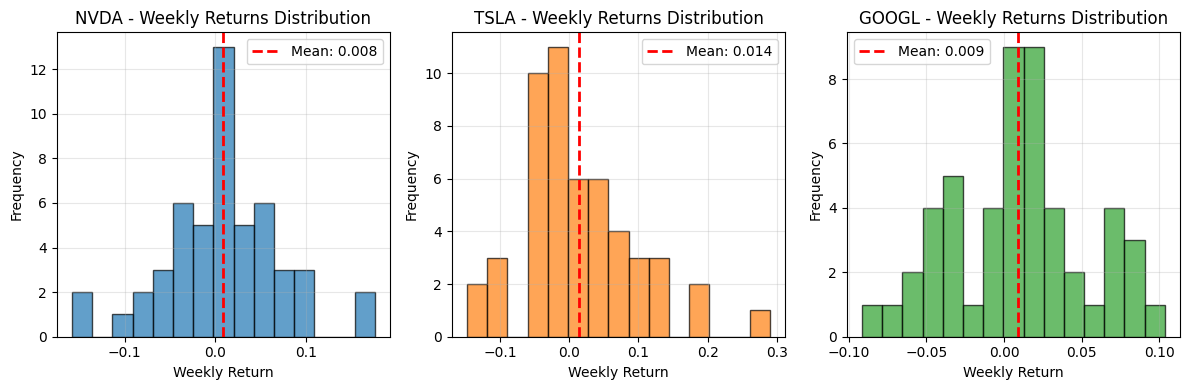


=== DESCRIPTIVE STATISTICS ===

NVDA:
  Mean: 0.0083
  Std Dev: 0.0644
  Min: -0.1581
  Max: 0.1762
  Skewness: -0.0149

TSLA:
  Mean: 0.0141
  Std Dev: 0.0821
  Min: -0.1481
  Max: 0.2901
  Skewness: 0.8109

GOOGL:
  Mean: 0.0092
  Std Dev: 0.0442
  Min: -0.0916
  Max: 0.1038
  Skewness: 0.0014


In [434]:
# 6.1 Distribution of Target Variable: Weekly Returns
print("=== WEEKLY RETURNS DISTRIBUTION ANALYSIS ===")

# Create subplots for histograms and boxplots
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

stocks = ['NVDA', 'TSLA', 'GOOGL']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for i, stock in enumerate(stocks):
    stock_data = merged_data[merged_data['stock'] == stock]
    returns = stock_data['weekly_return']
    
    # Histogram (top row)
    axes[i].hist(returns, bins=15, color=colors[i], alpha=0.7, edgecolor='black')
    axes[i].axvline(returns.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {returns.mean():.3f}')
    axes[i].set_title(f'{stock} - Weekly Returns Distribution')
    axes[i].set_xlabel('Weekly Return')
    axes[i].set_ylabel('Frequency')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n=== DESCRIPTIVE STATISTICS ===")
for stock in stocks:
    stock_data = merged_data[merged_data['stock'] == stock]
    returns = stock_data['weekly_return']
    
    print(f"\n{stock}:")
    print(f"  Mean: {returns.mean():.4f}")
    print(f"  Std Dev: {returns.std():.4f}")
    print(f"  Min: {returns.min():.4f}")
    print(f"  Max: {returns.max():.4f}")
    print(f"  Skewness: {skew(returns):.4f}")  # Add this line

### Insights from Weekly Returns Distribution

The descriptive statistics reveal distinct risk-return profiles across the three technology stocks during the analysis period:

**Volatility Hierarchy:**
- **TSLA** exhibits the highest volatility (Std Dev: 0.0821), confirming its reputation as the most unpredictable of the three
- **NVDA** shows moderate volatility (Std Dev: 0.0644) 
- **GOOGL** demonstrates the most stable behavior (Std Dev: 0.0442), approximately half as volatile as TSLA

**Return Characteristics:**
- All three stocks achieved positive average weekly returns, consistent with the overall bullish market context
- TSLA delivered the highest average returns (0.0141) but with substantially greater risk
- GOOGL offered the most favorable risk-return profile with steady, positive performance

**Distribution Patterns:**
- **TSLA** shows significant positive skewness (0.8109), indicating a tendency for occasional large positive returns that pull the average upward
- **NVDA** and **GOOGL** display nearly symmetric distributions (skewness ≈ 0), suggesting more balanced upside and downside movements
- The maximum weekly gains exceed maximum losses for all stocks, particularly for TSLA which saw a 29.0% weekly surge

**Implications for Sentiment Analysis:**
The varying volatility levels provide an ideal testing ground for our hypothesis—if Reddit sentiment correlates with returns, we would expect to see the strongest relationship with TSLA (highest volatility) and the weakest with GOOGL (lowest volatility).

## 6.2 Distribution of Predictor Variables: Sentiment Scores

We now examine the sentiment scores that form the basis of our predictive analysis. Understanding the distribution of VADER, TextBlob, and combined sentiment scores is crucial for assessing whether these variables contain meaningful signal for our correlation analysis.

This exploration answers fundamental questions: Do we have sufficient variation in sentiment scores to detect relationships with returns? Are the scores systematically biased in one direction? How consistent are the different sentiment measurement methods?

=== SENTIMENT SCORES DISTRIBUTION ANALYSIS ===


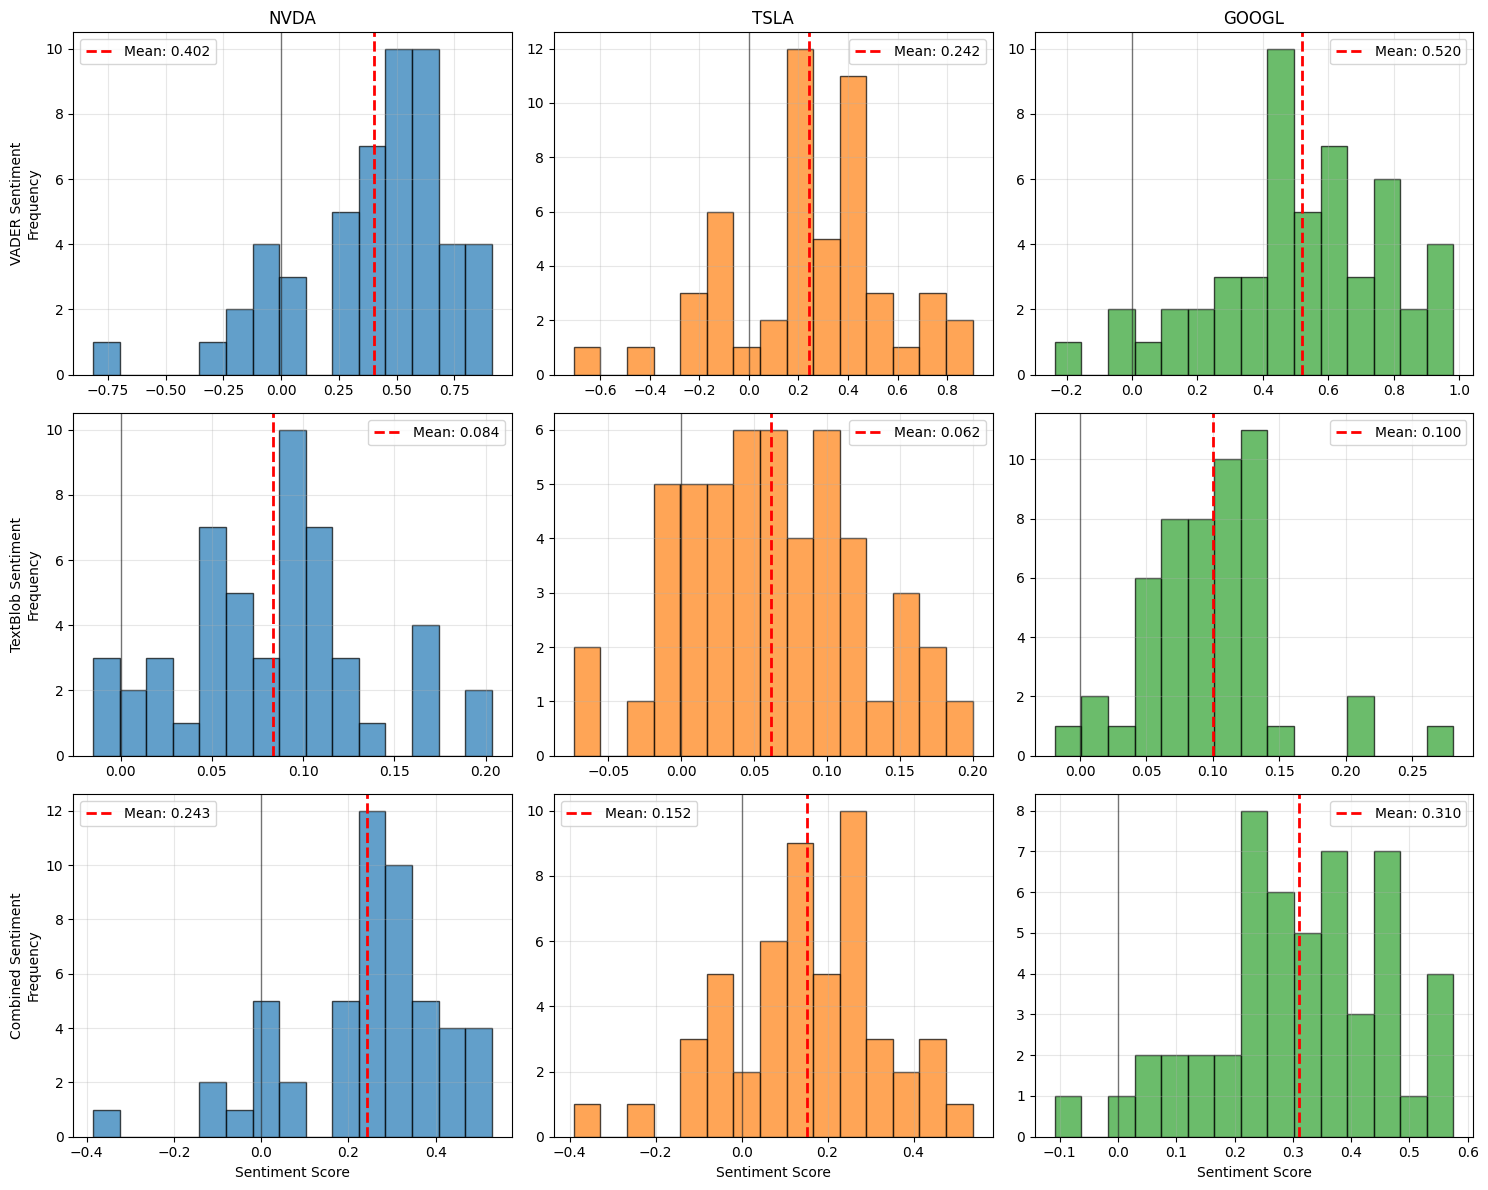


=== SENTIMENT DESCRIPTIVE STATISTICS ===

NVDA:
  VADER Sentiment:
    Mean: 0.4016
    Std Dev: 0.3418
    Min: -0.8149
    Max: 0.9119
    Skewness: -1.1671
    >0: 43/51 weeks (84.3%)
  TextBlob Sentiment:
    Mean: 0.0836
    Std Dev: 0.0517
    Min: -0.0151
    Max: 0.2034
    Skewness: 0.1927
    >0: 47/51 weeks (92.2%)
  Combined Sentiment:
    Mean: 0.2426
    Std Dev: 0.1812
    Min: -0.3851
    Max: 0.5284
    Skewness: -1.0135
    >0: 47/51 weeks (92.2%)

TSLA:
  VADER Sentiment:
    Mean: 0.2423
    Std Dev: 0.3178
    Min: -0.7067
    Max: 0.9028
    Skewness: -0.4246
    >0: 39/51 weeks (76.5%)
  TextBlob Sentiment:
    Mean: 0.0618
    Std Dev: 0.0611
    Min: -0.0736
    Max: 0.2000
    Skewness: 0.0766
    >0: 42/51 weeks (82.4%)
  Combined Sentiment:
    Mean: 0.1520
    Std Dev: 0.1791
    Min: -0.3902
    Max: 0.5374
    Skewness: -0.4509
    >0: 40/51 weeks (78.4%)

GOOGL:
  VADER Sentiment:
    Mean: 0.5195
    Std Dev: 0.2733
    Min: -0.2358
    Max: 0.9817
   

In [435]:
# 6.2 Distribution of Predictor Variables: Sentiment Scores
print("=== SENTIMENT SCORES DISTRIBUTION ANALYSIS ===")

# Create comprehensive sentiment analysis
fig, axes = plt.subplots(3, 3, figsize=(15, 12))

sentiment_columns = ['vader_score', 'textblob_score', 'combined_score']
sentiment_names = ['VADER Sentiment', 'TextBlob Sentiment', 'Combined Sentiment']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for i, stock in enumerate(stocks):
    stock_data = merged_data[merged_data['stock'] == stock]
    
    for j, (col, name) in enumerate(zip(sentiment_columns, sentiment_names)):
        sentiment_data = stock_data[col]
        
        # Histograms
        axes[j, i].hist(sentiment_data, bins=15, color=colors[i], alpha=0.7, edgecolor='black')
        axes[j, i].axvline(sentiment_data.mean(), color='red', linestyle='--', linewidth=2, 
                          label=f'Mean: {sentiment_data.mean():.3f}')
        axes[j, i].axvline(0, color='black', linestyle='-', alpha=0.5, linewidth=1)
        
        if i == 0:
            axes[j, i].set_ylabel(f'{name}\nFrequency')
        if j == 0:
            axes[j, i].set_title(f'{stock}')
        if j == 2:
            axes[j, i].set_xlabel('Sentiment Score')
            
        axes[j, i].legend()
        axes[j, i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print sentiment statistics
print("\n=== SENTIMENT DESCRIPTIVE STATISTICS ===")
for stock in stocks:
    stock_data = merged_data[merged_data['stock'] == stock]
    
    print(f"\n{stock}:")
    for col, name in zip(sentiment_columns, sentiment_names):
        sentiment_data = stock_data[col]
        print(f"  {name}:")
        print(f"    Mean: {sentiment_data.mean():.4f}")
        print(f"    Std Dev: {sentiment_data.std():.4f}")
        print(f"    Min: {sentiment_data.min():.4f}")
        print(f"    Max: {sentiment_data.max():.4f}")
        print(f"    Skewness: {skew(sentiment_data):.4f}")
        print(f"    >0: {(sentiment_data > 0).sum()}/51 weeks ({(sentiment_data > 0).sum()/51*100:.1f}%)")

### Insights from Sentiment Scores Distribution

The sentiment analysis reveals striking patterns in Reddit discussion sentiment across the three technology stocks:

**Overwhelming Optimism Bias:**
- **GOOGL** generated the most consistently positive sentiment, with 94-98% of weeks showing positive scores across all measurement methods
- **NVDA** followed with 84-92% positive weeks, demonstrating strong but slightly more varied sentiment
- **TSLA** showed the most balanced sentiment profile, though still predominantly positive (76-82% of weeks)

**Methodological Divergence:**
- **VADER** captured much stronger sentiment signals (means: 0.24-0.52) with greater variability, reflecting its sensitivity to social media language patterns
- **TextBlob** produced more conservative, tightly clustered scores (means: 0.06-0.10), suggesting it may be less responsive to the extremes of financial discussion
- The **combined scores** effectively averaged these approaches, providing moderate sentiment values with reduced volatility

**Sentiment Strength Hierarchy:**
- **GOOGL** attracted the most favorable sentiment overall, with combined scores averaging 0.31
- **NVDA** followed closely with 0.24 average combined sentiment
- **TSLA** generated the most tempered positive sentiment at 0.15, potentially reflecting its controversial nature among investors

**Distribution Characteristics:**
- All three stocks show negative skewness in VADER and combined scores, indicating occasional strongly negative sentiment weeks punctuate generally positive discussion
- TextBlob distributions are more symmetric, with TSLA and NVDA showing near-zero skewness
- The substantial standard deviations confirm meaningful week-to-week sentiment variation exists for correlation analysis

**Critical Implication for Hypothesis Testing:**
The strong positive sentiment bias across all stocks creates a challenging environment for detecting correlation with returns. With sentiment predominantly positive, we are essentially testing whether *degrees of optimism* rather than sentiment direction predict price movements.

## 6.3 Temporal Patterns Analysis

We now examine how post volume, sentiment, and returns evolve over time to identify potential trends, seasonal patterns, or structural breaks that could influence our correlation analysis. Understanding the temporal dynamics is crucial for recognizing whether external events or systematic patterns might confound the relationship between Reddit sentiment and stock returns.

This analysis helps answer critical questions: Are there periods of unusually high market discussion that coincide with major price movements? Do sentiment and returns show coordinated shifts over time that might suggest broader market regimes? Are there specific events or time periods that disproportionately drive any observed relationships?

=== TEMPORAL PATTERNS ANALYSIS ===


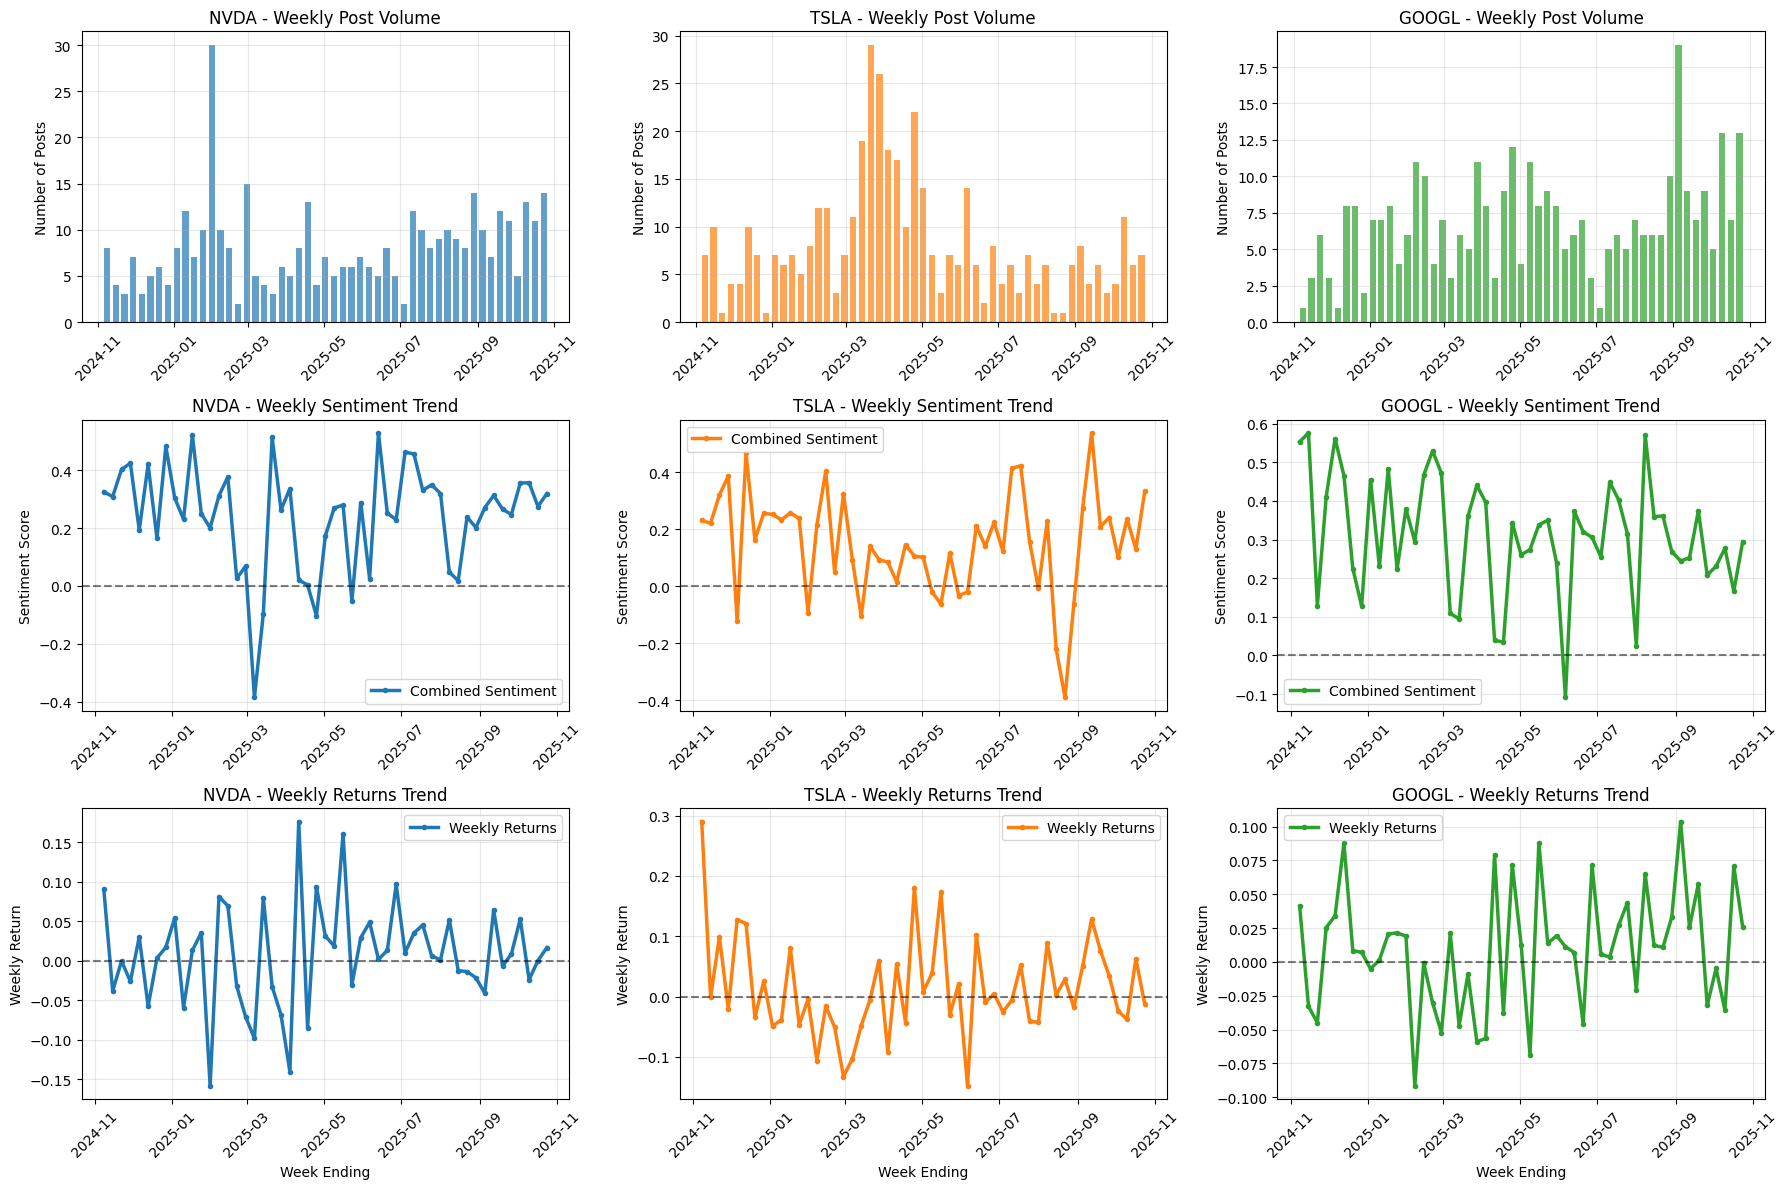


=== TEMPORAL STATISTICS ===

NVDA:
  Post Volume Trend: Early 8.4 → Mid 6.1 → Late 9.7
  Sentiment Trend: Early 0.295 → Mid 0.149 → Late 0.284
  High Volatility Weeks: 15/51 (29.4%)

TSLA:
  Post Volume Trend: Early 6.5 → Mid 12.9 → Late 5.1
  Sentiment Trend: Early 0.223 → Mid 0.072 → Late 0.160
  High Volatility Weeks: 14/51 (27.5%)

GOOGL:
  Post Volume Trend: Early 5.6 → Mid 6.9 → Late 7.9
  Sentiment Trend: Early 0.387 → Mid 0.245 → Late 0.297
  High Volatility Weeks: 17/51 (33.3%)


In [436]:
# 6.3 Temporal Patterns Analysis
print("=== TEMPORAL PATTERNS ANALYSIS ===")

# Create comprehensive temporal analysis
fig, axes = plt.subplots(3, 3, figsize=(18, 12))

for i, stock in enumerate(stocks):
    stock_data = merged_data[merged_data['stock'] == stock].sort_values('week_ending')
    
    # Plot 1: Post Volume over Time
    axes[0, i].bar(stock_data['week_ending'], stock_data['post_count'], 
                   color=colors[i], alpha=0.7, width=5)
    axes[0, i].set_title(f'{stock} - Weekly Post Volume')
    axes[0, i].set_ylabel('Number of Posts')
    axes[0, i].tick_params(axis='x', rotation=45)
    axes[0, i].grid(True, alpha=0.3)
    
    # Plot 2: Sentiment over Time
    axes[1, i].plot(stock_data['week_ending'], stock_data['combined_score'], 
                    color=colors[i], linewidth=2.5, marker='o', markersize=3, label='Combined Sentiment')
    axes[1, i].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[1, i].set_title(f'{stock} - Weekly Sentiment Trend')
    axes[1, i].set_ylabel('Sentiment Score')
    axes[1, i].tick_params(axis='x', rotation=45)
    axes[1, i].grid(True, alpha=0.3)
    axes[1, i].legend()
    
    # Plot 3: Returns over Time
    axes[2, i].plot(stock_data['week_ending'], stock_data['weekly_return'], 
                    color=colors[i], linewidth=2.5, marker='o', markersize=3, label='Weekly Returns')
    axes[2, i].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[2, i].set_title(f'{stock} - Weekly Returns Trend')
    axes[2, i].set_ylabel('Weekly Return')
    axes[2, i].set_xlabel('Week Ending')
    axes[2, i].tick_params(axis='x', rotation=45)
    axes[2, i].grid(True, alpha=0.3)
    axes[2, i].legend()

plt.tight_layout()
plt.show()

# Calculate temporal statistics
print("\n=== TEMPORAL STATISTICS ===")
for stock in stocks:
    stock_data = merged_data[merged_data['stock'] == stock].sort_values('week_ending')
    
    print(f"\n{stock}:")
    
    # Post volume trends
    early_posts = stock_data['post_count'].iloc[:17].mean()  # First 1/3
    mid_posts = stock_data['post_count'].iloc[17:34].mean()  # Middle 1/3  
    late_posts = stock_data['post_count'].iloc[34:].mean()   # Last 1/3
    print(f"  Post Volume Trend: Early {early_posts:.1f} → Mid {mid_posts:.1f} → Late {late_posts:.1f}")
    
    # Sentiment trends
    early_sentiment = stock_data['combined_score'].iloc[:17].mean()
    mid_sentiment = stock_data['combined_score'].iloc[17:34].mean()
    late_sentiment = stock_data['combined_score'].iloc[34:].mean()
    print(f"  Sentiment Trend: Early {early_sentiment:.3f} → Mid {mid_sentiment:.3f} → Late {late_sentiment:.3f}")
    
    # Volatility clusters
    high_vol_periods = len(stock_data[abs(stock_data['weekly_return']) > stock_data['weekly_return'].std()])
    print(f"  High Volatility Weeks: {high_vol_periods}/51 ({high_vol_periods/51*100:.1f}%)")

### Insights from Temporal Patterns Analysis

The temporal analysis reveals distinct patterns in how discussion volume, sentiment, and returns evolved throughout the study period:

**Discussion Volume Dynamics:**
- **TSLA** experienced the most dramatic volume fluctuations, with a mid-period surge to 12.9 posts/week followed by a sharp decline, suggesting episodic bursts of intense market discussion
- **NVDA** and **GOOGL** showed more stable discussion patterns, with NVDA seeing increased attention in the latter period while GOOGL maintained consistent engagement

**Sentiment Trajectories:**
- All three stocks exhibited a **mid-period sentiment dip**, with TSLA experiencing the most pronounced decline to near-neutral levels (0.072)
- **GOOGL** maintained the highest sentiment throughout, though it still followed the broader pattern of mid-period cooling
- The parallel sentiment declines across all stocks suggest **market-wide factors** rather than company-specific news drove sentiment patterns

**Volatility and Discussion Patterns:**
- **GOOGL** surprisingly showed the highest proportion of high-volatility weeks (33.3%), challenging its perception as the most stable stock
- The timing of TSLA's volume surge aligns with its mid-period sentiment decline, potentially indicating contentious or uncertain discussion phases
- NVDA's late-period volume increase coincides with sentiment recovery, suggesting renewed optimistic discussion

**Critical Implications for Correlation Analysis:**
The synchronized mid-period sentiment decline across all stocks represents a potential confounding factor. If this sentiment dip coincided with broader market conditions that also affected returns, it could create a spurious correlation. The episodic nature of discussion volume, particularly for TSLA, means sentiment measurements may be less reliable during low-engagement periods.

The temporal patterns suggest we should test whether the sentiment-return relationship remains consistent across different phases of our study period, particularly comparing the sentiment-dip period against the more optimistic early and late phases.

## 7. Relationship Analysis

We now directly test our core hypothesis by examining the quantitative relationship between Reddit sentiment and stock returns. This section moves from exploratory analysis to hypothesis testing, using statistical methods to measure whether the anticipated connection between online discussion sentiment and price movements actually exists in our data.

The correlation analysis provides the foundational evidence for answering our research question: Is there a statistically significant relationship between weekly sentiment scores and weekly stock returns across our three technology stocks?

### 7.1 Correlation Analysis (Quantitative Measurement)

This analysis quantifies the linear relationship between Reddit sentiment scores and weekly stock returns using Pearson correlation coefficients. For each stock and sentiment measurement method, we calculate both the correlation strength (r) and statistical significance (p-value) to determine whether observed relationships are likely genuine or due to random chance.

The R-squared values provide crucial context by indicating what percentage of return variation is explained by sentiment scores, helping us assess the practical importance of any statistically significant relationships.

=== CORRELATION ANALYSIS ===

=== CORRELATION RESULTS ===

NVDA:
  Vader        r =  0.020 (p = 0.889, R² = 0.000)
  Textblob     r =  0.108 (p = 0.452, R² = 0.012)
  Combined     r =  0.034 (p = 0.811, R² = 0.001)

TSLA:
  Vader        r =  0.124 (p = 0.386, R² = 0.015)
  Textblob     r = -0.077 (p = 0.590, R² = 0.006)
  Combined     r =  0.097 (p = 0.499, R² = 0.009)

GOOGL:
  Vader        r =  0.051 (p = 0.721, R² = 0.003)
  Textblob     r =  0.057 (p = 0.693, R² = 0.003)
  Combined     r =  0.055 (p = 0.700, R² = 0.003)

=== CORRELATION HEATMAP ===


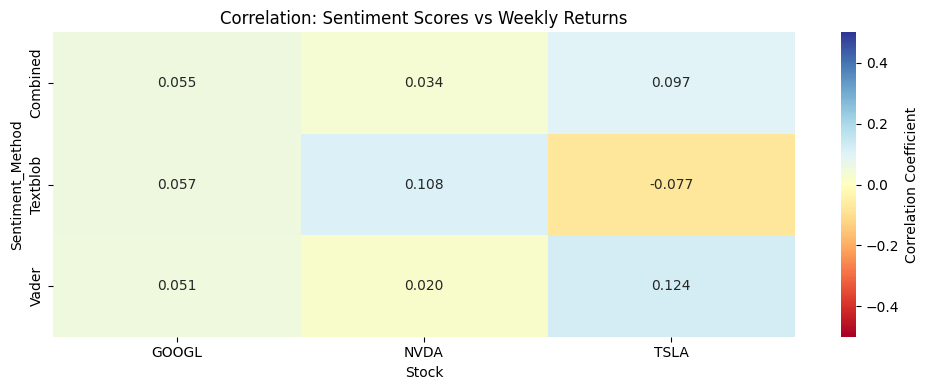


=== CORRELATION SUMMARY ===
Total significant correlations: 0/9 (0.0%)
Average correlation coefficient: 0.052
Average R-squared: 0.006

=== METHOD COMPARISON ===
                  Correlation  Significant  R_Squared
Sentiment_Method                                     
Combined                0.062            0      0.005
Textblob                0.029            0      0.007
Vader                   0.065            0      0.006


In [437]:
# 7.1 Correlation Analysis (Quantitative Measurement)
print("=== CORRELATION ANALYSIS ===")

# Calculate comprehensive correlation matrix
correlation_results = []

for stock in stocks:
    stock_data = merged_data[merged_data['stock'] == stock]
    
    for sentiment_col in ['vader_score', 'textblob_score', 'combined_score']:
        corr_coef, p_value = pearsonr(stock_data[sentiment_col], stock_data['weekly_return'])
        
        correlation_results.append({
            'Stock': stock,
            'Sentiment_Method': sentiment_col.replace('_score', '').title(),
            'Correlation': corr_coef,
            'P_Value': p_value,
            'Significant': p_value < 0.05,
            'R_Squared': corr_coef ** 2
        })

# Create results dataframe
corr_df = pd.DataFrame(correlation_results)

# Display results in a clean table
print("\n=== CORRELATION RESULTS ===")
for stock in stocks:
    print(f"\n{stock}:")
    stock_corr = corr_df[corr_df['Stock'] == stock]
    for _, row in stock_corr.iterrows():
        significance = "***" if row['P_Value'] < 0.05 else ""
        print(f"  {row['Sentiment_Method']:12} r = {row['Correlation']:6.3f}{significance} "
              f"(p = {row['P_Value']:5.3f}, R² = {row['R_Squared']:5.3f})")

# Create correlation heatmap for visualization
print("\n=== CORRELATION HEATMAP ===")
pivot_corr = corr_df.pivot(index='Sentiment_Method', columns='Stock', values='Correlation')
pivot_pvals = corr_df.pivot(index='Sentiment_Method', columns='Stock', values='P_Value')

plt.figure(figsize=(10, 4))
sns.heatmap(pivot_corr, annot=True, cmap='RdYlBu', center=0, 
            vmin=-0.5, vmax=0.5, fmt='.3f', 
            cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation: Sentiment Scores vs Weekly Returns')
plt.tight_layout()
plt.show()

# Summary statistics
print("\n=== CORRELATION SUMMARY ===")
print(f"Total significant correlations: {corr_df['Significant'].sum()}/9 ({corr_df['Significant'].sum()/9*100:.1f}%)")
print(f"Average correlation coefficient: {corr_df['Correlation'].mean():.3f}")
print(f"Average R-squared: {corr_df['R_Squared'].mean():.3f}")

# Method comparison
print("\n=== METHOD COMPARISON ===")
method_summary = corr_df.groupby('Sentiment_Method').agg({
    'Correlation': 'mean',
    'Significant': 'sum',
    'R_Squared': 'mean'
}).round(3)
print(method_summary)